In [16]:
from pathlib import Path
from sklearn.model_selection import KFold
import shutil
from ultralytics import YOLO
import pandas as pd
import os

In [3]:
import torch
torch.backends.cudnn.benchmark = True


In [4]:
from pathlib import Path

# Nombres de las clases (sin incluir background)
class_names = [
    "Vehiculos",
    "Bodegas",
    "Caminos",
    "Rios",
    "Zonas de mineria ilegal"
]

for dataset_name in ["modelo_yolov11_dataset_filtrado", "modelo_yolov11_dataset_completo"]:
    DATA_ROOT = Path(dataset_name)

    yaml_content = f"""\
        path: {DATA_ROOT.resolve()}
        train: train
        val: val
        test: test
        nc: {len(class_names)}
        names: {class_names}
        """


    yaml_path = DATA_ROOT / "dataset.yaml"
    with open(yaml_path, "w", encoding="utf-8") as f:
        f.write(yaml_content)

    print(f"✅ YAML generado en: {yaml_path}")


✅ YAML generado en: modelo_yolov11_dataset_filtrado\dataset.yaml
✅ YAML generado en: modelo_yolov11_dataset_completo\dataset.yaml


In [5]:
from pathlib import Path
from sklearn.model_selection import KFold
import shutil
from ultralytics import YOLO
import pandas as pd

def ejecutar_kfold_yolov8(
    dataset_name: str,
    class_names: list,
    model_weights: str = "yolov8s.pt",
    num_folds: int = 5,
    epochs: int = 40,
    batch_size: int = 16,
    img_size: int = 640,
    patience: int = 5
):
    DATA_ROOT = Path(dataset_name)
    IMAGES_DIR = DATA_ROOT / "train" / "images"
    LABELS_DIR = DATA_ROOT / "train" / "labels"
    CV_ROOT = Path(f"kfold_results_{dataset_name}")
    CV_ROOT.mkdir(parents=True, exist_ok=True)

    all_images = sorted(IMAGES_DIR.glob("*.jpg"))
    all_labels = [LABELS_DIR / (img.stem + ".txt") for img in all_images]
    assert all([lbl.exists() for lbl in all_labels]), "❌ Faltan archivos .txt para algunas imágenes."

    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    results_summary = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(all_images)):
        print(f"\n🔁 Entrenando fold {fold_idx + 1}/{num_folds}...")

        fold_dir = CV_ROOT / f"fold_{fold_idx}"
        train_img_dir = fold_dir / "images" / "train"
        val_img_dir = fold_dir / "images" / "val"
        train_lbl_dir = fold_dir / "labels" / "train"
        val_lbl_dir = fold_dir / "labels" / "val"
        for d in [train_img_dir, val_img_dir, train_lbl_dir, val_lbl_dir]:
            d.mkdir(parents=True, exist_ok=True)

        for idx in train_idx:
            shutil.copy(all_images[idx], train_img_dir)
            shutil.copy(all_labels[idx], train_lbl_dir)
        for idx in val_idx:
            shutil.copy(all_images[idx], val_img_dir)
            shutil.copy(all_labels[idx], val_lbl_dir)

        yaml_content = f"""\
            path: {fold_dir.resolve()}
            train: images/train
            val: images/val
            nc: {len(class_names)}
            names: {class_names}
            """


        yaml_path = fold_dir / "dataset.yaml"
        with open(yaml_path, "w", encoding="utf-8") as f:
            f.write(yaml_content)

        run_name = f"{dataset_name}_cv_fold_{fold_idx}"
        project_dir = Path("runs/detect")
        last_ckpt = project_dir / run_name / "weights" / "last.pt"

        if last_ckpt.exists():
            # Verificamos si ya se entrenaron todos los epochs
            completed_flag = (project_dir / run_name / "results.csv").exists()

            if completed_flag:
                print(f"✅ Fold {fold_idx} ya completado previamente. Saltando...")
                continue  # Saltamos al siguiente fold
            else:
                print(f"🔄 Reanudando fold {fold_idx} desde checkpoint: {last_ckpt}")
                model = YOLO(str(last_ckpt))
                results = model.train(
                    resume=True,
                    epochs=epochs,
                    name=run_name
                )

        else:
            print(f"🚀 Entrenando fold {fold_idx} desde cero...")
            model = YOLO(model_weights)
            results = model.train(
                data=str(yaml_path),
                epochs=epochs,
                imgsz=img_size,
                batch=batch_size,
                name=run_name,
                patience=patience
            )

        metrics = model.val(data=str(yaml_path)).results_dict
        metrics["fold"] = fold_idx
        results_summary.append(metrics)

    df_results = pd.DataFrame(results_summary)
    csv_output = CV_ROOT / "cv_results_summary.csv"
    df_results.to_csv(csv_output, index=False)
    print(f"\n✅ Cross-validation completa. Resultados guardados en: {csv_output}")

def entrenar_modelo_final(
    dataset_name: str,
    class_names: list,
    model_weights: str = "yolov8s.pt",
    epochs: int = 80,
    batch_size: int = 16,
    img_size: int = 640,
    patience: int = 10
):
    DATA_ROOT = Path(dataset_name)
    FINAL_OUTPUT_DIR = Path(f"final_model_{dataset_name}")
    FINAL_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

    yaml_path = DATA_ROOT / "dataset.yaml"
    run_name = f"{dataset_name}_final"
    project_dir = Path("runs/detect")
    last_ckpt = project_dir / run_name / "weights" / "last.pt"

    if last_ckpt.exists():
        print(f"🔄 Reanudando modelo final desde checkpoint: {last_ckpt}")
        model = YOLO(str(last_ckpt))
        results = model.train(
            resume=True,
            epochs=epochs,
            name=run_name
        )
    else:
        print(f"🚀 Entrenando modelo final sobre todo el dataset: {dataset_name}...")
        model = YOLO(model_weights)
        results = model.train(
            data=str(yaml_path),
            epochs=epochs,
            imgsz=img_size,
            batch=batch_size,
            name=run_name,
            patience=patience
        )

    final_model_path = FINAL_OUTPUT_DIR / f"{dataset_name}_final_model.pt"
    model.save(str(final_model_path))
    print(f"\n✅ Modelo final guardado en: {final_model_path}")

# Entrenamiento del multiclass para dataset filtrado

## K-fold Filtrado

In [6]:
ejecutar_kfold_yolov8(
    dataset_name="modelo_yolov11_dataset_filtrado",
    class_names=["Vehiculos", "Bodegas", "Caminos", "Rios", "Zonas de mineria ilegal"]
)


🔁 Entrenando fold 1/5...
🚀 Entrenando fold 0 desde cero...
New https://pypi.org/project/ultralytics/8.3.134 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=kfold_results_modelo_yolov11_dataset_filtrado\fold_0\dataset.yaml, epochs=40, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=modelo_yolov11_dataset_filtrado_cv_fold_05, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_filtrado\fold_0\labels\train.cache... 6606 images, 1638 backgrounds, 0 corrupt: 100%|██████████| 6606/6606 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 29.816.0 MB/s, size: 323.1 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_filtrado\fold_0\labels\val.cache... 1652 images, 424 backgrounds, 0 corrupt: 100%|██████████| 1652/1652 [00:00<?, ?it/s]


Plotting labels to runs\detect\modelo_yolov11_dataset_filtrado_cv_fold_05\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/14 16:00:34 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/14 16:00:38 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(2fe0be57745948dfb228f7f3aa44cf7f) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\modelo_yolov11_dataset_filtrado_cv_fold_05
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40     0.748G       2.21      3.096      2.075         46        640: 100%|██████████| 413/413 [01:44<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.17it/s]

                   all       1652       1936      0.426      0.335      0.289      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40       3.8G      2.101      2.377      2.023         27        640: 100%|██████████| 413/413 [01:35<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.50it/s]


                   all       1652       1936      0.317      0.361      0.258     0.0851

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      3.98G      2.047      2.259      1.985         45        640: 100%|██████████| 413/413 [01:32<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.80it/s]


                   all       1652       1936      0.396      0.359      0.302      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40         4G      1.995      2.153      1.974         24        640: 100%|██████████| 413/413 [01:32<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.18it/s]

                   all       1652       1936      0.412      0.465      0.382      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40         4G      1.892      1.987      1.885         51        640: 100%|██████████| 413/413 [01:34<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.36it/s]


                   all       1652       1936      0.504      0.529      0.463      0.212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40         4G      1.807      1.859      1.802         47        640: 100%|██████████| 413/413 [01:35<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.29it/s]


                   all       1652       1936      0.547      0.533      0.527      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40         4G      1.764      1.755      1.769         31        640: 100%|██████████| 413/413 [01:35<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.54it/s]


                   all       1652       1936      0.542      0.577      0.557      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40         4G      1.685      1.635      1.687         33        640: 100%|██████████| 413/413 [01:40<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.42it/s]

                   all       1652       1936      0.596      0.615       0.62      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40         4G      1.614      1.559      1.643         23        640: 100%|██████████| 413/413 [01:43<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.64it/s]

                   all       1652       1936       0.65      0.618      0.643      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40         4G      1.571      1.485      1.597         31        640: 100%|██████████| 413/413 [01:37<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.32it/s]


                   all       1652       1936      0.637      0.659      0.662      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40         4G      1.525      1.427      1.569         37        640: 100%|██████████| 413/413 [01:38<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.53it/s]


                   all       1652       1936      0.618      0.661      0.664      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40         4G      1.487      1.374      1.531         28        640: 100%|██████████| 413/413 [01:34<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.56it/s]


                   all       1652       1936      0.672      0.695      0.708      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40         4G      1.455      1.313      1.509         27        640: 100%|██████████| 413/413 [01:34<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.66it/s]


                   all       1652       1936      0.648       0.71      0.713      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40         4G      1.419       1.27      1.475         50        640: 100%|██████████| 413/413 [01:34<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.67it/s]

                   all       1652       1936      0.703      0.683      0.716      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40         4G      1.368      1.226      1.438         24        640: 100%|██████████| 413/413 [01:35<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.64it/s]


                   all       1652       1936      0.709      0.708      0.747      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40         4G       1.35      1.183      1.425         24        640: 100%|██████████| 413/413 [01:38<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.66it/s]


                   all       1652       1936      0.678      0.715      0.728      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40         4G      1.329       1.16      1.408         28        640: 100%|██████████| 413/413 [01:36<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.35it/s]

                   all       1652       1936      0.704      0.735      0.748      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40         4G      1.277      1.114      1.379         40        640: 100%|██████████| 413/413 [01:38<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.69it/s]

                   all       1652       1936      0.709      0.769      0.769      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40         4G      1.261      1.086      1.362         31        640: 100%|██████████| 413/413 [01:35<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.35it/s]

                   all       1652       1936      0.723       0.73       0.76      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40         4G      1.244      1.061      1.348         44        640: 100%|██████████| 413/413 [01:34<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.79it/s]


                   all       1652       1936      0.714      0.772      0.779      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40         4G      1.222       1.04      1.335         40        640: 100%|██████████| 413/413 [01:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.75it/s]


                   all       1652       1936      0.722      0.775      0.784      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40         4G      1.194      1.005      1.314         49        640: 100%|██████████| 413/413 [01:35<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.73it/s]


                   all       1652       1936      0.733      0.762      0.778      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40         4G      1.187     0.9957      1.309         34        640: 100%|██████████| 413/413 [01:36<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.70it/s]


                   all       1652       1936      0.727      0.783      0.784      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40         4G      1.147     0.9485      1.285         18        640: 100%|██████████| 413/413 [01:33<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.45it/s]

                   all       1652       1936      0.749      0.767      0.799       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40         4G      1.125     0.9374      1.275         40        640: 100%|██████████| 413/413 [01:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.79it/s]

                   all       1652       1936      0.747      0.781      0.799      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40         4G      1.119     0.9237      1.265         22        640: 100%|██████████| 413/413 [01:34<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.36it/s]

                   all       1652       1936      0.752      0.782      0.808      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40         4G      1.084     0.8924       1.24         34        640: 100%|██████████| 413/413 [01:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.82it/s]

                   all       1652       1936      0.768      0.785      0.817      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40         4G      1.074     0.8791      1.234         66        640: 100%|██████████| 413/413 [01:34<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.39it/s]

                   all       1652       1936       0.77      0.792      0.819      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40         4G      1.047     0.8558      1.219         36        640: 100%|██████████| 413/413 [01:35<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.49it/s]

                   all       1652       1936      0.771      0.797       0.82      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40         4G      1.033     0.8348      1.201         51        640: 100%|██████████| 413/413 [01:38<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.36it/s]

                   all       1652       1936      0.756      0.803      0.818      0.591


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40         4G     0.9455     0.7352      1.167          8        640: 100%|██████████| 413/413 [01:38<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.65it/s]

                   all       1652       1936      0.795      0.793      0.833      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40         4G     0.9241     0.7048      1.151         13        640: 100%|██████████| 413/413 [01:34<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.72it/s]

                   all       1652       1936      0.766      0.804      0.831        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40         4G     0.8921     0.6844      1.131          9        640: 100%|██████████| 413/413 [01:36<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.41it/s]

                   all       1652       1936      0.793      0.795      0.832      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40         4G     0.8686     0.6724      1.125         24        640: 100%|██████████| 413/413 [01:41<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.01it/s]

                   all       1652       1936      0.799      0.793      0.841      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40         4G     0.8437     0.6449      1.108         23        640: 100%|██████████| 413/413 [01:39<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.44it/s]

                   all       1652       1936      0.773       0.83      0.845      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40         4G     0.8178     0.6309      1.088         17        640: 100%|██████████| 413/413 [01:40<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.37it/s]


                   all       1652       1936      0.794      0.809      0.844      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40         4G     0.7988     0.6112      1.079         24        640: 100%|██████████| 413/413 [01:35<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.20it/s]

                   all       1652       1936      0.799      0.821       0.85      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40         4G     0.7704     0.5935      1.062         20        640: 100%|██████████| 413/413 [01:35<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.70it/s]


                   all       1652       1936      0.792      0.831      0.854       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40         4G     0.7486     0.5837      1.054         20        640: 100%|██████████| 413/413 [01:35<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:14<00:00,  3.67it/s]

                   all       1652       1936      0.803      0.831      0.855      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40         4G     0.7387     0.5731      1.046         13        640: 100%|██████████| 413/413 [01:32<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.96it/s]

                   all       1652       1936      0.808       0.82      0.858      0.648



40 epochs completed in 1.218 hours.
Optimizer stripped from runs\detect\modelo_yolov11_dataset_filtrado_cv_fold_05\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\modelo_yolov11_dataset_filtrado_cv_fold_05\weights\best.pt, 22.5MB

Validating runs\detect\modelo_yolov11_dataset_filtrado_cv_fold_05\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.51it/s]


                   all       1652       1936      0.808       0.82      0.858      0.647
             Vehiculos        311        318      0.838      0.997      0.944      0.901
               Bodegas        134        425      0.653      0.632      0.701      0.352
               Caminos        262        429      0.771      0.758      0.795      0.455
                  Rios        249        422      0.833      0.852       0.89      0.612
Zonas de mineria ilegal        325        342      0.943      0.863      0.958      0.917
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_filtrado_cv_fold_05
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, rea

val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_filtrado\fold_0\labels\val.cache... 1652 images, 424 backgrounds, 0 corrupt: 100%|██████████| 1652/1652 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:14<00:00,  7.41it/s]


                   all       1652       1936      0.808       0.82      0.857      0.648
             Vehiculos        311        318      0.838      0.997      0.944      0.901
               Bodegas        134        425      0.652      0.631      0.701      0.352
               Caminos        262        429      0.773      0.758      0.795      0.456
                  Rios        249        422      0.833      0.851       0.89      0.612
Zonas de mineria ilegal        325        342      0.945      0.863      0.958      0.919
Speed: 0.1ms preprocess, 4.0ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_filtrado_cv_fold_052

🔁 Entrenando fold 2/5...
✅ Fold 1 ya completado previamente. Saltando...

🔁 Entrenando fold 3/5...
✅ Fold 2 ya completado previamente. Saltando...

🔁 Entrenando fold 4/5...
✅ Fold 3 ya completado previamente. Saltando...

🔁 Entrenando fold 5/5...
🚀 Entrenando fold 4 desde cero...
New https://pypi.org/project

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_filtrado\fold_4\labels\train... 6607 images, 1680 backgrounds, 0 corrupt: 100%|██████████| 6607/6607 [00:14<00:00, 453.32it/s]


train: New cache created: E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_filtrado\fold_4\labels\train.cache
val: Fast image access  (ping: 0.20.1 ms, read: 17.16.1 MB/s, size: 320.4 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_filtrado\fold_4\labels\val... 1651 images, 382 backgrounds, 0 corrupt: 100%|██████████| 1651/1651 [00:04<00:00, 381.51it/s]


val: New cache created: E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_filtrado\fold_4\labels\val.cache
Plotting labels to runs\detect\modelo_yolov11_dataset_filtrado_cv_fold_4\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/14 17:18:06 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/14 17:18:06 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(ac07c0a620e0441e8addac9d1fceb6bd) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\modelo_yolov11_dataset_filtrado_cv_fold_4
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40       1.2G      2.199      3.097      2.061         32        640: 100%|██████████| 413/413 [01:43<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.28it/s]


                   all       1651       1888      0.318      0.304      0.233     0.0878

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      3.81G      2.097      2.367      2.015         31        640: 100%|██████████| 413/413 [01:35<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.54it/s]


                   all       1651       1888      0.263      0.362      0.236     0.0821

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      3.99G      2.061      2.266      1.993         34        640: 100%|██████████| 413/413 [01:33<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.55it/s]


                   all       1651       1888      0.399      0.418      0.318      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40         4G      1.988      2.141      1.927         33        640: 100%|██████████| 413/413 [01:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.70it/s]


                   all       1651       1888      0.488      0.466      0.434      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40         4G      1.902      1.981      1.856         28        640: 100%|██████████| 413/413 [01:31<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.75it/s]


                   all       1651       1888      0.562       0.47      0.495      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40         4G       1.82      1.849      1.774         34        640: 100%|██████████| 413/413 [01:31<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.45it/s]


                   all       1651       1888      0.521      0.552      0.544      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40         4G      1.737      1.739      1.719         55        640: 100%|██████████| 413/413 [01:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.73it/s]


                   all       1651       1888       0.56      0.601      0.595      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40         4G      1.686      1.641      1.677         21        640: 100%|██████████| 413/413 [01:33<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.36it/s]

                   all       1651       1888      0.633      0.585      0.627      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40         4G      1.645       1.56      1.645         43        640: 100%|██████████| 413/413 [01:35<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.66it/s]


                   all       1651       1888      0.634      0.631      0.651       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40         4G      1.594        1.5      1.595         40        640: 100%|██████████| 413/413 [01:34<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.70it/s]


                   all       1651       1888       0.65      0.656      0.663      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40         4G      1.544      1.443      1.564         31        640: 100%|██████████| 413/413 [01:34<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:13<00:00,  3.85it/s]

                   all       1651       1888       0.67      0.681      0.701      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40         4G      1.501      1.382       1.53         27        640: 100%|██████████| 413/413 [01:36<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.16it/s]

                   all       1651       1888      0.707      0.657      0.721      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40         4G      1.474       1.32        1.5         55        640: 100%|██████████| 413/413 [01:37<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.16it/s]

                   all       1651       1888      0.717      0.683      0.727      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40         4G      1.409      1.261      1.464         32        640: 100%|██████████| 413/413 [01:38<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.41it/s]


                   all       1651       1888      0.684      0.705       0.72      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40         4G       1.38      1.214      1.441         27        640: 100%|██████████| 413/413 [01:35<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.04it/s]


                   all       1651       1888      0.704       0.69      0.733      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40         4G      1.361      1.182       1.42         40        640: 100%|██████████| 413/413 [01:33<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.72it/s]

                   all       1651       1888       0.67      0.734       0.73      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40         4G      1.331      1.145      1.395         30        640: 100%|██████████| 413/413 [01:32<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.44it/s]

                   all       1651       1888      0.708      0.722      0.748      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40         4G       1.31      1.129      1.393         44        640: 100%|██████████| 413/413 [01:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.59it/s]

                   all       1651       1888      0.719      0.743      0.762      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40         4G      1.285      1.095      1.371         35        640: 100%|██████████| 413/413 [01:34<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.61it/s]


                   all       1651       1888      0.727      0.764      0.784      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40         4G       1.26      1.077      1.353         45        640: 100%|██████████| 413/413 [01:33<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.68it/s]


                   all       1651       1888      0.732      0.759      0.784       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40         4G      1.235      1.038      1.331         30        640: 100%|██████████| 413/413 [01:36<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:14<00:00,  3.64it/s]

                   all       1651       1888      0.749      0.755       0.79      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40         4G       1.21      1.012      1.321         25        640: 100%|██████████| 413/413 [01:35<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.55it/s]

                   all       1651       1888      0.743      0.771      0.797      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40         4G      1.188     0.9863      1.299         35        640: 100%|██████████| 413/413 [01:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.59it/s]

                   all       1651       1888      0.734      0.793        0.8      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40         4G      1.163     0.9583      1.283         27        640: 100%|██████████| 413/413 [01:33<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.45it/s]


                   all       1651       1888      0.759       0.77      0.794      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40         4G      1.137     0.9461      1.266         31        640: 100%|██████████| 413/413 [01:36<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.51it/s]

                   all       1651       1888      0.766      0.765      0.801      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40         4G      1.113     0.9196      1.255         32        640: 100%|██████████| 413/413 [01:35<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.52it/s]

                   all       1651       1888      0.735      0.806      0.807      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40         4G      1.099     0.8945      1.236         33        640: 100%|██████████| 413/413 [01:34<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.54it/s]

                   all       1651       1888      0.766      0.795      0.818      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40         4G      1.078     0.8812      1.227         78        640: 100%|██████████| 413/413 [01:34<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.53it/s]


                   all       1651       1888      0.762      0.803       0.82      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40         4G      1.059     0.8681      1.211         50        640: 100%|██████████| 413/413 [01:36<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.51it/s]


                   all       1651       1888      0.775        0.8      0.829      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40         4G      1.035     0.8352      1.197         26        640: 100%|██████████| 413/413 [01:34<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.60it/s]

                   all       1651       1888      0.774      0.806      0.826      0.596


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40         4G     0.9769     0.7491      1.175         27        640: 100%|██████████| 413/413 [01:32<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.66it/s]

                   all       1651       1888      0.788      0.793      0.826      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40         4G     0.9418     0.7108      1.153         13        640: 100%|██████████| 413/413 [01:32<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.65it/s]

                   all       1651       1888       0.77      0.814      0.838      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40         4G      0.911      0.694      1.144         18        640: 100%|██████████| 413/413 [01:34<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.50it/s]

                   all       1651       1888      0.798      0.794       0.84      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40         4G     0.8891     0.6728      1.122         17        640: 100%|██████████| 413/413 [01:34<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.49it/s]


                   all       1651       1888      0.797      0.796      0.836      0.614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40         4G     0.8539     0.6498      1.102         12        640: 100%|██████████| 413/413 [01:34<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.39it/s]


                   all       1651       1888      0.782      0.816      0.842      0.626

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40         4G     0.8304     0.6323      1.092         15        640: 100%|██████████| 413/413 [01:34<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.38it/s]

                   all       1651       1888      0.792      0.818       0.85      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40         4G     0.8096     0.6093      1.074         16        640: 100%|██████████| 413/413 [01:38<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.46it/s]

                   all       1651       1888      0.804       0.81      0.842      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40         4G     0.7909     0.6002      1.064         16        640: 100%|██████████| 413/413 [01:33<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.69it/s]

                   all       1651       1888      0.806      0.811      0.848      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40         4G     0.7707     0.5873      1.054         18        640: 100%|██████████| 413/413 [01:32<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.67it/s]

                   all       1651       1888      0.798      0.814      0.846       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40         4G     0.7518     0.5741      1.045         14        640: 100%|██████████| 413/413 [01:31<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.62it/s]

                   all       1651       1888      0.806      0.813      0.848      0.645



40 epochs completed in 1.201 hours.
Optimizer stripped from runs\detect\modelo_yolov11_dataset_filtrado_cv_fold_4\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\modelo_yolov11_dataset_filtrado_cv_fold_4\weights\best.pt, 22.5MB

Validating runs\detect\modelo_yolov11_dataset_filtrado_cv_fold_4\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.32it/s]


                   all       1651       1888      0.807      0.812      0.848      0.645
             Vehiculos        380        392      0.886          1      0.952      0.913
               Bodegas        111        375      0.638      0.549      0.638      0.327
               Caminos        231        354       0.75      0.749      0.805      0.478
                  Rios        247        401      0.845      0.863      0.894      0.599
Zonas de mineria ilegal        341        366      0.916      0.899      0.952      0.908
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_filtrado_cv_fold_4
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read

val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_filtrado\fold_4\labels\val.cache... 1651 images, 382 backgrounds, 0 corrupt: 100%|██████████| 1651/1651 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:14<00:00,  7.18it/s]


                   all       1651       1888      0.809      0.811      0.848      0.645
             Vehiculos        380        392      0.888          1      0.952      0.915
               Bodegas        111        375      0.641      0.547      0.636      0.327
               Caminos        231        354       0.75      0.749      0.804      0.478
                  Rios        247        401      0.846      0.863      0.894      0.598
Zonas de mineria ilegal        341        366      0.919      0.899      0.953      0.907
Speed: 0.1ms preprocess, 3.6ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_filtrado_cv_fold_42

✅ Cross-validation completa. Resultados guardados en: kfold_results_modelo_yolov11_dataset_filtrado\cv_results_summary.csv


## Modelo Final - Filtrado

In [7]:
entrenar_modelo_final(
    dataset_name="modelo_yolov11_dataset_filtrado",
    class_names=["Vehiculos", "Bodegas", "Caminos", "Rios", "Zonas de mineria ilegal"]
)


🚀 Entrenando modelo final sobre todo el dataset: modelo_yolov11_dataset_filtrado...
New https://pypi.org/project/ultralytics/8.3.134 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=modelo_yolov11_dataset_filtrado\dataset.yaml, epochs=80, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=modelo_yolov11_dataset_filtrado_final3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_filtrado\train\labels.cache... 8258 images, 2062 backgrounds, 0 corrupt: 100%|██████████| 8258/8258 [00:00<?, ?it/s]


val: Fast image access  (ping: 1.01.1 ms, read: 13.15.1 MB/s, size: 271.5 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_filtrado\val\labels.cache... 984 images, 237 backgrounds, 0 corrupt: 100%|██████████| 984/984 [00:00<?, ?it/s]


Plotting labels to runs\detect\modelo_yolov11_dataset_filtrado_final3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/14 18:37:21 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/14 18:37:21 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(8577d3595ccc4677bf556e6f4d60ab2f) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\modelo_yolov11_dataset_filtrado_final3
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80     0.514G      2.301      3.328      2.122          2        640: 100%|██████████| 517/517 [02:03<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.13it/s]

                   all        984       1103      0.354      0.398      0.342      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80      3.47G      1.965      2.088      1.791          6        640: 100%|██████████| 517/517 [01:58<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.15it/s]

                   all        984       1103      0.485      0.491      0.466      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80      3.67G      1.973      2.059      1.803          2        640: 100%|██████████| 517/517 [01:56<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.42it/s]

                   all        984       1103      0.412      0.413      0.369      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      3.67G      1.999       2.08      1.824          3        640: 100%|██████████| 517/517 [01:57<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.42it/s]

                   all        984       1103      0.434      0.454      0.415      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80      3.67G      1.926      1.962       1.77          7        640: 100%|██████████| 517/517 [02:01<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.30it/s]

                   all        984       1103      0.456      0.502      0.466      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      3.67G       1.84      1.828      1.719          4        640: 100%|██████████| 517/517 [02:02<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.15it/s]

                   all        984       1103      0.588       0.57      0.581      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80      3.67G      1.759      1.718      1.648          6        640: 100%|██████████| 517/517 [01:58<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.48it/s]

                   all        984       1103      0.554      0.604      0.603      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80      3.67G      1.717      1.631      1.616          1        640: 100%|██████████| 517/517 [02:01<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.19it/s]

                   all        984       1103      0.583      0.587      0.592      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80      3.67G      1.658       1.56      1.577          7        640: 100%|██████████| 517/517 [02:02<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.44it/s]

                   all        984       1103      0.641      0.622      0.648       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80      3.67G      1.599      1.498      1.534          7        640: 100%|██████████| 517/517 [02:00<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.52it/s]

                   all        984       1103      0.628      0.663      0.687      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80      3.67G      1.571      1.417      1.503          3        640: 100%|██████████| 517/517 [02:01<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.21it/s]

                   all        984       1103      0.677       0.68      0.738      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80      3.67G       1.51      1.371      1.466          3        640: 100%|██████████| 517/517 [02:00<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.48it/s]

                   all        984       1103      0.651      0.698      0.714       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80      3.67G      1.498      1.329      1.454          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.62it/s]

                   all        984       1103      0.676      0.706      0.747      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80      3.67G      1.466      1.285       1.43          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.61it/s]

                   all        984       1103       0.74      0.724      0.776      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80      3.67G      1.442      1.277       1.41          1        640: 100%|██████████| 517/517 [01:58<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.32it/s]

                   all        984       1103      0.736      0.723      0.782      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80      3.67G      1.401      1.227      1.391          2        640: 100%|██████████| 517/517 [02:00<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.25it/s]

                   all        984       1103      0.758      0.736      0.783      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80      3.67G      1.381      1.188      1.376          1        640: 100%|██████████| 517/517 [02:02<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.13it/s]

                   all        984       1103      0.752      0.733      0.789      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80      3.67G      1.342      1.143      1.352          1        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.59it/s]

                   all        984       1103       0.72      0.764      0.792      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80      3.67G      1.328      1.126      1.338          4        640: 100%|██████████| 517/517 [01:55<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.56it/s]

                   all        984       1103      0.714      0.757      0.797      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80      3.67G      1.311      1.103      1.326          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.63it/s]

                   all        984       1103      0.732      0.765      0.807      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80      3.67G      1.281      1.094      1.312          1        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.58it/s]


                   all        984       1103      0.762      0.796      0.816      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80      3.67G      1.276      1.072      1.302          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.66it/s]


                   all        984       1103      0.778      0.785      0.814      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80      3.67G      1.251      1.032      1.285          2        640: 100%|██████████| 517/517 [01:56<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.66it/s]

                   all        984       1103      0.749      0.795      0.815      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80      3.67G      1.216      1.009      1.263          4        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.12it/s]

                   all        984       1103      0.767      0.793      0.824      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80      3.67G      1.209     0.9954      1.261          3        640: 100%|██████████| 517/517 [02:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.13it/s]

                   all        984       1103      0.786      0.803      0.839      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80      3.67G      1.195      0.984      1.251          6        640: 100%|██████████| 517/517 [02:07<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.33it/s]

                   all        984       1103       0.77      0.812      0.846      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80      3.67G      1.168     0.9579      1.235          4        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.58it/s]


                   all        984       1103      0.778       0.81      0.834      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80      3.67G      1.166     0.9546      1.234          8        640: 100%|██████████| 517/517 [01:59<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.52it/s]

                   all        984       1103      0.776      0.807      0.831      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80      3.67G      1.146     0.9275      1.218         12        640: 100%|██████████| 517/517 [01:59<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.58it/s]

                   all        984       1103      0.775      0.809      0.841      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80      3.67G      1.132     0.9066      1.206          6        640: 100%|██████████| 517/517 [01:56<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.52it/s]

                   all        984       1103      0.784      0.824      0.844      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80      3.67G      1.117     0.8971      1.202          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.70it/s]

                   all        984       1103      0.786      0.823      0.853      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80      3.67G      1.099     0.8862      1.196          5        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.72it/s]

                   all        984       1103        0.8      0.831      0.865      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80      3.67G      1.091     0.8805      1.187          1        640: 100%|██████████| 517/517 [01:56<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.48it/s]

                   all        984       1103      0.781       0.83      0.857      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80      3.67G      1.089     0.8637      1.179          1        640: 100%|██████████| 517/517 [01:57<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.85it/s]


                   all        984       1103      0.773      0.841      0.852      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80      3.67G      1.069     0.8555      1.172          9        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.75it/s]

                   all        984       1103       0.78      0.836      0.856       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80      3.67G      1.053     0.8387      1.168          3        640: 100%|██████████| 517/517 [01:57<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.83it/s]

                   all        984       1103        0.8      0.834      0.852       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80      3.67G      1.045     0.8314      1.155          5        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.78it/s]

                   all        984       1103       0.81      0.843      0.871      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80      3.67G       1.04     0.8293       1.16          7        640: 100%|██████████| 517/517 [01:55<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.75it/s]

                   all        984       1103      0.797      0.844      0.867      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80      3.67G      1.028     0.8186       1.15          0        640: 100%|██████████| 517/517 [01:56<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.67it/s]

                   all        984       1103      0.825      0.846       0.87      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80      3.67G      1.011     0.8087      1.145         12        640: 100%|██████████| 517/517 [01:56<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.68it/s]

                   all        984       1103      0.813      0.839      0.869      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80      3.67G      1.009     0.7964      1.139          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.71it/s]

                   all        984       1103      0.814      0.846      0.869      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80      3.67G     0.9842     0.7777       1.12          0        640: 100%|██████████| 517/517 [01:55<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.73it/s]


                   all        984       1103      0.813      0.857      0.871      0.647

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80      3.67G      0.988     0.7732      1.126          9        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.75it/s]

                   all        984       1103      0.817      0.841      0.874      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80      3.67G     0.9656     0.7647      1.115          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.74it/s]

                   all        984       1103      0.813      0.832      0.875      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80      3.67G     0.9564     0.7493      1.108          6        640: 100%|██████████| 517/517 [01:56<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.58it/s]

                   all        984       1103      0.846      0.844      0.883      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80      3.67G     0.9576     0.7544      1.109          9        640: 100%|██████████| 517/517 [01:57<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.64it/s]

                   all        984       1103      0.835      0.851      0.887      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80      3.67G     0.9324     0.7328      1.096          5        640: 100%|██████████| 517/517 [01:58<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.47it/s]

                   all        984       1103      0.817      0.852      0.878      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80      3.67G     0.9222     0.7293      1.088          8        640: 100%|██████████| 517/517 [01:57<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.64it/s]

                   all        984       1103      0.833      0.859      0.883      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80      3.67G     0.9209     0.7243      1.089          5        640: 100%|██████████| 517/517 [01:57<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.76it/s]

                   all        984       1103       0.83      0.849      0.881      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80      3.67G     0.9143      0.714      1.085          5        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.74it/s]

                   all        984       1103      0.842      0.857      0.881      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80      3.67G     0.9026     0.7058       1.08          4        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.71it/s]

                   all        984       1103      0.825      0.852      0.882      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80      3.67G     0.8851     0.6913       1.07          3        640: 100%|██████████| 517/517 [01:55<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.70it/s]

                   all        984       1103      0.828       0.85      0.878      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80      3.67G     0.8843     0.6975      1.072          9        640: 100%|██████████| 517/517 [01:57<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.55it/s]

                   all        984       1103      0.833      0.843      0.883      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80      3.67G      0.876      0.678      1.064          1        640: 100%|██████████| 517/517 [01:58<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.47it/s]

                   all        984       1103       0.84      0.861      0.888      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80      3.67G      0.867     0.6801       1.06          2        640: 100%|██████████| 517/517 [01:57<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.61it/s]

                   all        984       1103      0.825      0.865      0.889      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80      3.67G      0.863     0.6743      1.058          2        640: 100%|██████████| 517/517 [01:57<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.59it/s]

                   all        984       1103      0.837      0.865      0.891      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80      3.67G     0.8532     0.6625      1.052          6        640: 100%|██████████| 517/517 [01:56<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.67it/s]


                   all        984       1103      0.844      0.859      0.893      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80      3.67G     0.8308     0.6458      1.041          0        640: 100%|██████████| 517/517 [01:56<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.76it/s]

                   all        984       1103      0.841      0.857      0.889      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/80      3.67G     0.8256     0.6494      1.042          7        640: 100%|██████████| 517/517 [01:55<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.78it/s]

                   all        984       1103       0.84      0.861      0.894      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/80      3.67G     0.8173     0.6458      1.043          4        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.70it/s]


                   all        984       1103      0.835       0.87      0.893        0.7

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/80      3.67G     0.8058     0.6324      1.036          2        640: 100%|██████████| 517/517 [01:55<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.64it/s]


                   all        984       1103      0.849      0.854      0.894      0.705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/80      3.67G     0.8101     0.6337      1.034          6        640: 100%|██████████| 517/517 [01:55<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.80it/s]

                   all        984       1103      0.841      0.868      0.894      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/80      3.67G     0.7941     0.6183      1.025          4        640: 100%|██████████| 517/517 [01:55<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.73it/s]

                   all        984       1103      0.839      0.875      0.896       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/80      3.67G     0.7987      0.627      1.027          3        640: 100%|██████████| 517/517 [01:52<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.08it/s]


                   all        984       1103      0.851      0.854      0.894      0.709

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/80      3.67G     0.7718     0.6142      1.021          3        640: 100%|██████████| 517/517 [01:53<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.03it/s]

                   all        984       1103      0.851      0.854      0.896      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/80      3.67G     0.7707     0.6093      1.017          3        640: 100%|██████████| 517/517 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.07it/s]

                   all        984       1103      0.844      0.869      0.892       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/80      3.67G      0.754     0.5985      1.011          3        640: 100%|██████████| 517/517 [01:51<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.06it/s]

                   all        984       1103       0.84      0.871      0.895      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/80      3.67G     0.7565     0.6032      1.012          4        640: 100%|██████████| 517/517 [01:51<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.94it/s]

                   all        984       1103      0.849      0.866      0.896      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/80      3.67G     0.7415     0.5835      1.005          4        640: 100%|██████████| 517/517 [01:55<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.62it/s]

                   all        984       1103      0.849      0.859      0.894      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/80      3.67G     0.7324     0.5818     0.9991          8        640: 100%|██████████| 517/517 [01:58<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.17it/s]

                   all        984       1103      0.844      0.863      0.898      0.718


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/80      3.67G     0.6541     0.4974      0.958          2        640: 100%|██████████| 517/517 [02:03<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.34it/s]

                   all        984       1103      0.851      0.854      0.897      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/80      3.67G     0.6221     0.4833     0.9425          7        640: 100%|██████████| 517/517 [02:03<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.07it/s]

                   all        984       1103       0.86      0.855      0.897      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/80      3.67G     0.6035     0.4746     0.9418          1        640: 100%|██████████| 517/517 [02:03<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.40it/s]

                   all        984       1103      0.854       0.85      0.896      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/80      3.67G     0.5915     0.4635     0.9362          1        640: 100%|██████████| 517/517 [02:07<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  3.90it/s]

                   all        984       1103      0.851      0.857      0.892      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/80      3.67G     0.5859     0.4587      0.928          0        640: 100%|██████████| 517/517 [02:08<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.86it/s]

                   all        984       1103      0.847      0.859      0.892      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      76/80      3.67G     0.5745     0.4535     0.9268          1        640: 100%|██████████| 517/517 [02:07<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  3.96it/s]

                   all        984       1103      0.851      0.861      0.897      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      77/80      3.67G      0.564     0.4428     0.9183          1        640: 100%|██████████| 517/517 [02:06<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.04it/s]

                   all        984       1103      0.843      0.862      0.898      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      78/80      3.67G     0.5514     0.4329     0.9176          2        640: 100%|██████████| 517/517 [02:02<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.15it/s]

                   all        984       1103      0.845       0.86      0.896      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      79/80      3.67G     0.5446     0.4358     0.9118          1        640: 100%|██████████| 517/517 [01:59<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  3.97it/s]

                   all        984       1103      0.846      0.862      0.899       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      80/80      3.67G      0.538     0.4266     0.9085          1        640: 100%|██████████| 517/517 [02:05<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  3.92it/s]

                   all        984       1103      0.838      0.866      0.897      0.729



80 epochs completed in 2.805 hours.
Optimizer stripped from runs\detect\modelo_yolov11_dataset_filtrado_final3\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\modelo_yolov11_dataset_filtrado_final3\weights\best.pt, 22.5MB

Validating runs\detect\modelo_yolov11_dataset_filtrado_final3\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.46it/s]


                   all        984       1103      0.846      0.861      0.897       0.73
             Vehiculos        233        238      0.861          1      0.942       0.93
               Bodegas         65        218      0.686      0.702      0.733      0.372
               Caminos        134        222      0.816      0.806      0.881      0.627
                  Rios        137        205      0.926      0.951      0.977      0.776
Zonas de mineria ilegal        207        220      0.941      0.845      0.955      0.946
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_filtrado_final3
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'

✅ Modelo final guardado en: final_model_modelo_yolov11_dataset_filtrado\modelo_yolov11_dataset_filtrado_final_model.pt


# Entrenamiento del multiclass para dataset completo

## K-fold Completo

In [8]:
ejecutar_kfold_yolov8(
    dataset_name="modelo_yolov11_dataset_completo",
    class_names=["Vehiculos", "Bodegas", "Caminos", "Rios", "Zonas de mineria ilegal"]
)


🔁 Entrenando fold 1/5...
🚀 Entrenando fold 0 desde cero...
New https://pypi.org/project/ultralytics/8.3.134 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=kfold_results_modelo_yolov11_dataset_completo\fold_0\dataset.yaml, epochs=40, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=modelo_yolov11_dataset_completo_cv_fold_0, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=F

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_0\labels\train... 6586 images, 1613 backgrounds, 0 corrupt: 100%|██████████| 6586/6586 [00:14<00:00, 453.28it/s]


train: New cache created: E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_0\labels\train.cache
val: Fast image access  (ping: 0.20.0 ms, read: 10.64.3 MB/s, size: 284.4 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_0\labels\val... 1647 images, 421 backgrounds, 0 corrupt: 100%|██████████| 1647/1647 [00:04<00:00, 399.10it/s]


val: New cache created: E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_0\labels\val.cache
Plotting labels to runs\detect\modelo_yolov11_dataset_completo_cv_fold_0\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/14 21:30:01 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/14 21:30:01 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(6dc5d2e47afe40f4ae4748efa0599500) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\modelo_yolov11_dataset_completo_cv_fold_0
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      1.11G      2.202      3.099      2.052         19        640: 100%|██████████| 412/412 [01:47<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:13<00:00,  3.87it/s]

                   all       1647       1987      0.297      0.345      0.245     0.0788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      3.67G      2.115      2.393      2.016         23        640: 100%|██████████| 412/412 [01:42<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.18it/s]


                   all       1647       1987      0.303      0.433      0.295      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      3.87G      2.041      2.255      1.967         45        640: 100%|██████████| 412/412 [01:39<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.05it/s]


                   all       1647       1987      0.388      0.429      0.357      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      3.87G      1.958      2.103      1.897         21        640: 100%|██████████| 412/412 [01:35<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.36it/s]


                   all       1647       1987      0.461      0.504      0.446       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      3.87G      1.876      1.968       1.83         32        640: 100%|██████████| 412/412 [01:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.32it/s]

                   all       1647       1987      0.542      0.529      0.514      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      3.87G      1.817      1.838      1.767         36        640: 100%|██████████| 412/412 [01:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.40it/s]


                   all       1647       1987      0.565      0.527      0.539      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      3.87G      1.739      1.736      1.709         26        640: 100%|██████████| 412/412 [01:35<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.26it/s]


                   all       1647       1987      0.604      0.522      0.549      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      3.87G      1.668      1.628      1.657         11        640: 100%|██████████| 412/412 [01:33<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.38it/s]

                   all       1647       1987       0.61      0.611      0.613      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      3.87G      1.626       1.56       1.62         19        640: 100%|██████████| 412/412 [01:33<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.41it/s]

                   all       1647       1987      0.588      0.597      0.589      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      3.87G      1.575      1.491      1.574         25        640: 100%|██████████| 412/412 [01:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.42it/s]

                   all       1647       1987      0.648       0.63       0.66       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      3.87G      1.518      1.408      1.541         22        640: 100%|██████████| 412/412 [01:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.47it/s]

                   all       1647       1987      0.679       0.65      0.684      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      3.87G      1.473      1.346      1.507         33        640: 100%|██████████| 412/412 [01:32<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.38it/s]

                   all       1647       1987       0.66      0.673      0.697      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      3.87G      1.452        1.3      1.488         25        640: 100%|██████████| 412/412 [01:29<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.73it/s]


                   all       1647       1987      0.687      0.673      0.716      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      3.87G        1.4       1.26      1.451         29        640: 100%|██████████| 412/412 [01:29<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.91it/s]

                   all       1647       1987      0.701      0.711       0.73       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      3.87G      1.368      1.216      1.426         22        640: 100%|██████████| 412/412 [01:29<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.90it/s]

                   all       1647       1987      0.706      0.701      0.733      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      3.87G      1.323      1.163        1.4         16        640: 100%|██████████| 412/412 [01:29<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.93it/s]

                   all       1647       1987      0.694      0.733      0.751      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      3.87G      1.302      1.133      1.374         23        640: 100%|██████████| 412/412 [01:29<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.90it/s]

                   all       1647       1987      0.705      0.753      0.763      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      3.87G      1.297      1.128      1.367         21        640: 100%|██████████| 412/412 [01:29<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.94it/s]

                   all       1647       1987      0.744      0.733      0.767      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      3.87G      1.261      1.086      1.348         26        640: 100%|██████████| 412/412 [01:29<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.78it/s]

                   all       1647       1987      0.741      0.758      0.788      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      3.87G      1.219      1.037      1.322         41        640: 100%|██████████| 412/412 [01:29<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.92it/s]

                   all       1647       1987      0.746      0.734      0.778      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      3.87G      1.204      1.016      1.307         21        640: 100%|██████████| 412/412 [01:29<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.94it/s]

                   all       1647       1987      0.755      0.763      0.794      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      3.87G      1.185      1.007      1.297         25        640: 100%|██████████| 412/412 [01:29<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.77it/s]

                   all       1647       1987      0.746      0.779      0.795      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      3.87G      1.164     0.9826      1.283         19        640: 100%|██████████| 412/412 [01:29<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.89it/s]

                   all       1647       1987      0.761      0.774        0.8      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      3.87G      1.139     0.9472      1.265         16        640: 100%|██████████| 412/412 [01:29<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.91it/s]

                   all       1647       1987      0.756      0.778      0.802      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      3.87G      1.119     0.9193       1.25         33        640: 100%|██████████| 412/412 [01:31<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.76it/s]

                   all       1647       1987      0.737      0.805      0.805      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      3.87G      1.085     0.8977      1.225         22        640: 100%|██████████| 412/412 [01:31<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.91it/s]

                   all       1647       1987       0.76      0.778      0.812      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      3.87G      1.069     0.8925      1.219         31        640: 100%|██████████| 412/412 [01:29<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.93it/s]

                   all       1647       1987      0.757      0.776      0.811       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      3.87G      1.054     0.8683      1.209         22        640: 100%|██████████| 412/412 [01:32<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.17it/s]

                   all       1647       1987      0.766      0.789      0.818      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      3.87G      1.026     0.8471      1.194         18        640: 100%|██████████| 412/412 [01:39<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:14<00:00,  3.64it/s]

                   all       1647       1987      0.766      0.803      0.824      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      3.87G      1.012     0.8194      1.178         26        640: 100%|██████████| 412/412 [01:40<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.38it/s]

                   all       1647       1987       0.77      0.798      0.826      0.589


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      3.87G     0.9564     0.7328      1.155          9        640: 100%|██████████| 412/412 [01:34<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.29it/s]

                   all       1647       1987      0.781      0.778      0.818      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      3.87G     0.9072     0.6967       1.13         14        640: 100%|██████████| 412/412 [01:34<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.39it/s]

                   all       1647       1987      0.793       0.79       0.83      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      3.87G     0.8844     0.6721      1.117         13        640: 100%|██████████| 412/412 [01:34<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:14<00:00,  3.63it/s]


                   all       1647       1987      0.778      0.793      0.827      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      3.87G     0.8577     0.6584      1.101         16        640: 100%|██████████| 412/412 [01:38<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.12it/s]


                   all       1647       1987      0.797      0.794       0.84      0.609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      3.87G     0.8271     0.6276      1.082          8        640: 100%|██████████| 412/412 [01:35<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.42it/s]

                   all       1647       1987      0.789      0.807       0.84      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      3.87G     0.8034     0.6145      1.067          8        640: 100%|██████████| 412/412 [01:34<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.31it/s]

                   all       1647       1987      0.788      0.796      0.841      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      3.87G     0.7765     0.5922      1.058          8        640: 100%|██████████| 412/412 [01:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.36it/s]

                   all       1647       1987      0.795      0.807      0.843      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      3.87G      0.757     0.5777      1.042          8        640: 100%|██████████| 412/412 [01:34<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.42it/s]

                   all       1647       1987      0.784      0.812      0.847      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      3.87G     0.7386     0.5721      1.039         10        640: 100%|██████████| 412/412 [01:34<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.53it/s]

                   all       1647       1987      0.803       0.81      0.849      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      3.87G     0.7231     0.5595      1.031          3        640: 100%|██████████| 412/412 [01:33<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.47it/s]

                   all       1647       1987      0.787      0.822       0.85       0.64



40 epochs completed in 1.187 hours.
Optimizer stripped from runs\detect\modelo_yolov11_dataset_completo_cv_fold_0\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\modelo_yolov11_dataset_completo_cv_fold_0\weights\best.pt, 22.5MB

Validating runs\detect\modelo_yolov11_dataset_completo_cv_fold_0\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.17it/s]


                   all       1647       1987      0.787      0.822       0.85       0.64
             Vehiculos        348        355      0.866      0.994      0.947       0.91
               Bodegas        129        497      0.662       0.61      0.681      0.328
               Caminos        247        404      0.693      0.767      0.775      0.458
                  Rios        233        384      0.838      0.849      0.891      0.595
Zonas de mineria ilegal        327        347      0.875      0.889      0.955      0.909
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_completo_cv_fold_0
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.1 ms, read

val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_0\labels\val.cache... 1647 images, 421 backgrounds, 0 corrupt: 100%|██████████| 1647/1647 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 103/103 [00:13<00:00,  7.44it/s]


                   all       1647       1987      0.786      0.822      0.849       0.64
             Vehiculos        348        355      0.866      0.994      0.948      0.911
               Bodegas        129        497      0.662       0.61       0.68      0.327
               Caminos        247        404       0.69      0.765      0.772      0.458
                  Rios        233        384      0.837      0.852      0.891      0.596
Zonas de mineria ilegal        327        347      0.875       0.89      0.955      0.909
Speed: 0.1ms preprocess, 3.8ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_completo_cv_fold_02

🔁 Entrenando fold 2/5...
🚀 Entrenando fold 1 desde cero...
New https://pypi.org/project/ultralytics/8.3.134 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=yolov8s

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_1\labels\train... 6586 images, 1616 backgrounds, 0 corrupt: 100%|██████████| 6586/6586 [00:13<00:00, 497.80it/s]


train: New cache created: E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_1\labels\train.cache
val: Fast image access  (ping: 0.30.1 ms, read: 12.95.1 MB/s, size: 268.9 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_1\labels\val... 1647 images, 418 backgrounds, 0 corrupt: 100%|██████████| 1647/1647 [00:03<00:00, 417.83it/s]


val: New cache created: E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_1\labels\val.cache
Plotting labels to runs\detect\modelo_yolov11_dataset_completo_cv_fold_1\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/14 22:46:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/14 22:46:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(597d7fdb00694f1f85dd2cbed24155ac) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\modelo_yolov11_dataset_completo_cv_fold_1
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      3.83G      2.212      3.109      2.052         17        640: 100%|██████████| 412/412 [01:39<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.40it/s]


                   all       1647       1812      0.269      0.339      0.211     0.0737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      4.02G      2.099      2.387      1.998         14        640: 100%|██████████| 412/412 [01:34<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.42it/s]


                   all       1647       1812      0.299      0.381      0.244     0.0832

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      4.04G      2.052      2.259      1.994         38        640: 100%|██████████| 412/412 [01:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.38it/s]


                   all       1647       1812      0.359      0.353       0.31      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      4.04G      1.987      2.137      1.926         25        640: 100%|██████████| 412/412 [01:34<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.30it/s]


                   all       1647       1812      0.464      0.467      0.431      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      4.04G      1.896      1.986      1.844         26        640: 100%|██████████| 412/412 [01:34<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.30it/s]


                   all       1647       1812      0.465      0.497      0.476      0.215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      4.04G      1.832      1.873      1.793         28        640: 100%|██████████| 412/412 [01:34<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.31it/s]


                   all       1647       1812      0.552      0.533      0.533      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      4.04G       1.75      1.744      1.727         23        640: 100%|██████████| 412/412 [01:34<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.47it/s]

                   all       1647       1812       0.56      0.574      0.578       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      4.04G      1.711      1.672      1.682         13        640: 100%|██████████| 412/412 [01:32<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.43it/s]

                   all       1647       1812      0.591      0.595      0.587      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      4.04G      1.645      1.571      1.634         18        640: 100%|██████████| 412/412 [01:32<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.45it/s]

                   all       1647       1812       0.58      0.635      0.622      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      4.04G      1.587      1.503      1.588         21        640: 100%|██████████| 412/412 [01:32<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.52it/s]

                   all       1647       1812      0.658      0.667       0.68      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      4.04G       1.53      1.416      1.552         18        640: 100%|██████████| 412/412 [01:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.35it/s]


                   all       1647       1812      0.644      0.669      0.679      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      4.04G      1.493      1.365      1.524         39        640: 100%|██████████| 412/412 [01:34<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.27it/s]

                   all       1647       1812      0.677      0.689      0.704      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      4.04G      1.468      1.329      1.496         23        640: 100%|██████████| 412/412 [01:34<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.25it/s]


                   all       1647       1812      0.656       0.73      0.711       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      4.04G      1.403      1.262      1.447         46        640: 100%|██████████| 412/412 [01:34<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.36it/s]

                   all       1647       1812      0.702      0.731       0.74       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      4.04G      1.373      1.219      1.432         18        640: 100%|██████████| 412/412 [01:42<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.13it/s]

                   all       1647       1812      0.717      0.745      0.757      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      4.04G      1.346      1.186      1.406         18        640: 100%|██████████| 412/412 [01:40<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:13<00:00,  3.99it/s]

                   all       1647       1812      0.676      0.738      0.743      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      4.04G      1.323      1.156       1.39         20        640: 100%|██████████| 412/412 [01:50<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.01it/s]

                   all       1647       1812      0.705      0.755      0.751      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      4.04G      1.291       1.12      1.371         26        640: 100%|██████████| 412/412 [01:38<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.19it/s]

                   all       1647       1812      0.732      0.742      0.767      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      4.04G      1.277      1.109      1.355         24        640: 100%|██████████| 412/412 [01:38<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.22it/s]

                   all       1647       1812      0.703      0.756      0.762      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      4.04G      1.242      1.049      1.333         40        640: 100%|██████████| 412/412 [01:40<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.08it/s]

                   all       1647       1812      0.737      0.773      0.781      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      4.04G      1.224      1.033      1.322         22        640: 100%|██████████| 412/412 [01:40<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.03it/s]

                   all       1647       1812      0.751      0.786      0.788      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      4.04G      1.202       1.02      1.309         27        640: 100%|██████████| 412/412 [01:44<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:13<00:00,  3.96it/s]


                   all       1647       1812      0.737      0.777      0.789      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      4.04G      1.187     0.9946      1.302         20        640: 100%|██████████| 412/412 [01:48<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.05it/s]


                   all       1647       1812      0.751      0.777      0.803      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      4.04G       1.15     0.9673      1.276         15        640: 100%|██████████| 412/412 [01:42<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.14it/s]

                   all       1647       1812      0.765      0.791      0.806      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      4.04G      1.144     0.9499      1.262         38        640: 100%|██████████| 412/412 [01:42<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.18it/s]

                   all       1647       1812      0.748       0.81      0.806      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      4.04G      1.113     0.9239       1.25         19        640: 100%|██████████| 412/412 [01:39<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.17it/s]

                   all       1647       1812      0.749      0.819      0.814      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      4.04G      1.091     0.9014      1.237         22        640: 100%|██████████| 412/412 [01:40<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.08it/s]


                   all       1647       1812      0.792      0.809      0.828      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      4.04G      1.076     0.8919      1.224         25        640: 100%|██████████| 412/412 [01:40<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.01it/s]

                   all       1647       1812      0.778      0.807      0.825      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      4.04G      1.056     0.8742      1.205         19        640: 100%|██████████| 412/412 [01:40<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:12<00:00,  4.08it/s]

                   all       1647       1812       0.76      0.838      0.832      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      4.04G       1.04     0.8425      1.195         36        640: 100%|██████████| 412/412 [01:38<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.46it/s]

                   all       1647       1812      0.784      0.809      0.838      0.603


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      4.04G     0.9673     0.7453      1.169          8        640: 100%|██████████| 412/412 [01:31<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.94it/s]

                   all       1647       1812      0.789      0.811       0.84        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      4.04G     0.9255      0.718       1.15          8        640: 100%|██████████| 412/412 [01:28<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.99it/s]

                   all       1647       1812      0.786      0.814      0.842      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      4.04G     0.9083     0.6968      1.135         12        640: 100%|██████████| 412/412 [01:29<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.77it/s]

                   all       1647       1812      0.766      0.834      0.842      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      4.04G      0.882     0.6786      1.115          5        640: 100%|██████████| 412/412 [01:30<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.81it/s]

                   all       1647       1812      0.784      0.827      0.844      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      4.04G     0.8534     0.6593      1.104          7        640: 100%|██████████| 412/412 [01:30<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.84it/s]

                   all       1647       1812      0.794      0.821       0.85      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      4.04G     0.8252      0.634      1.084          8        640: 100%|██████████| 412/412 [01:30<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.66it/s]

                   all       1647       1812        0.8      0.833      0.859      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      4.04G     0.8054     0.6136      1.075          9        640: 100%|██████████| 412/412 [01:29<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.98it/s]

                   all       1647       1812      0.781      0.846      0.854      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      4.04G     0.7834     0.6001       1.06          9        640: 100%|██████████| 412/412 [01:29<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.02it/s]

                   all       1647       1812      0.808      0.829      0.861      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      4.04G     0.7653     0.5886       1.05          8        640: 100%|██████████| 412/412 [01:29<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.00it/s]

                   all       1647       1812       0.79      0.849      0.863      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      4.04G     0.7504      0.578      1.044          3        640: 100%|██████████| 412/412 [01:28<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.12it/s]

                   all       1647       1812      0.796      0.845      0.863      0.654



40 epochs completed in 1.217 hours.
Optimizer stripped from runs\detect\modelo_yolov11_dataset_completo_cv_fold_1\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\modelo_yolov11_dataset_completo_cv_fold_1\weights\best.pt, 22.5MB

Validating runs\detect\modelo_yolov11_dataset_completo_cv_fold_1\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.77it/s]


                   all       1647       1812      0.797      0.845      0.864      0.654
             Vehiculos        334        341      0.899          1      0.966      0.925
               Bodegas        100        289      0.593      0.731      0.693      0.333
               Caminos        263        419      0.776      0.716      0.785       0.47
                  Rios        239        404      0.805      0.874      0.908      0.615
Zonas de mineria ilegal        334        359      0.913      0.905      0.967      0.926
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_completo_cv_fold_1
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read

val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_1\labels\val.cache... 1647 images, 418 backgrounds, 0 corrupt: 100%|██████████| 1647/1647 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 103/103 [00:12<00:00,  8.11it/s]


                   all       1647       1812      0.797      0.845      0.864      0.654
             Vehiculos        334        341      0.899          1      0.966      0.928
               Bodegas        100        289      0.593      0.731      0.693      0.333
               Caminos        263        419      0.774      0.716      0.785      0.468
                  Rios        239        404      0.804      0.874      0.908      0.616
Zonas de mineria ilegal        334        359      0.913      0.905      0.967      0.926
Speed: 0.1ms preprocess, 3.3ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_completo_cv_fold_12

🔁 Entrenando fold 3/5...
🚀 Entrenando fold 2 desde cero...
New https://pypi.org/project/ultralytics/8.3.134 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=yolov8s

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_2\labels\train... 6586 images, 1640 backgrounds, 0 corrupt: 100%|██████████| 6586/6586 [00:10<00:00, 631.39it/s]


train: New cache created: E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_2\labels\train.cache
val: Fast image access  (ping: 0.30.1 ms, read: 16.04.9 MB/s, size: 267.7 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_2\labels\val... 1647 images, 394 backgrounds, 0 corrupt: 100%|██████████| 1647/1647 [00:03<00:00, 485.91it/s]


val: New cache created: E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_2\labels\val.cache
Plotting labels to runs\detect\modelo_yolov11_dataset_completo_cv_fold_2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/15 00:03:52 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/15 00:03:53 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(a755dd10d26a4865ae0ea84936b7dd10) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\modelo_yolov11_dataset_completo_cv_fold_2
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      3.69G      2.206      3.074      2.014         19        640: 100%|██████████| 412/412 [01:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.86it/s]


                   all       1647       1827      0.288      0.324      0.222     0.0724

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      3.88G      2.095      2.373      1.985         27        640: 100%|██████████| 412/412 [01:29<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.89it/s]


                   all       1647       1827      0.416      0.411      0.337      0.121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      3.89G      2.048      2.273      1.963         42        640: 100%|██████████| 412/412 [01:27<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.95it/s]


                   all       1647       1827      0.347      0.433      0.343      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      3.89G      1.982      2.148      1.907         20        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.87it/s]


                   all       1647       1827      0.465      0.485      0.426      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      3.89G      1.898      1.996      1.842         28        640: 100%|██████████| 412/412 [01:27<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.88it/s]


                   all       1647       1827      0.475      0.533      0.476      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      3.89G       1.81      1.869      1.768         38        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.86it/s]

                   all       1647       1827      0.587       0.57       0.58       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      3.89G      1.739      1.766      1.716         19        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.92it/s]

                   all       1647       1827      0.573      0.584      0.577      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      3.89G      1.676      1.643      1.665         17        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.95it/s]

                   all       1647       1827      0.607      0.614      0.624      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      3.89G      1.622       1.58      1.623         24        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.98it/s]

                   all       1647       1827      0.644      0.606      0.641      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      3.89G      1.587      1.509      1.588         17        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.00it/s]

                   all       1647       1827       0.63      0.651      0.663      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      3.89G      1.522      1.453      1.549         22        640: 100%|██████████| 412/412 [01:28<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.92it/s]


                   all       1647       1827      0.659      0.653      0.684      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      3.89G      1.486      1.387      1.518         29        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.87it/s]

                   all       1647       1827      0.658       0.69      0.707      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      3.89G      1.457      1.329       1.49         27        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.95it/s]

                   all       1647       1827      0.662      0.735      0.737      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      3.89G      1.402      1.266      1.448         41        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.02it/s]

                   all       1647       1827        0.7       0.73      0.747      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      3.89G      1.378      1.224      1.432         26        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.03it/s]

                   all       1647       1827      0.698      0.735      0.752      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      3.89G      1.348      1.182      1.414         22        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.00it/s]

                   all       1647       1827      0.675      0.767      0.748      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      3.89G      1.315      1.165      1.385         21        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.96it/s]

                   all       1647       1827      0.683       0.75      0.751      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      3.89G      1.296      1.128      1.372         26        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.05it/s]

                   all       1647       1827      0.732      0.729      0.761        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      3.89G      1.262      1.101      1.352         30        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.02it/s]

                   all       1647       1827      0.737      0.767      0.779      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      3.89G      1.235      1.065      1.328         37        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.02it/s]

                   all       1647       1827      0.749      0.801      0.796      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      3.89G      1.209      1.041      1.311         22        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.10it/s]

                   all       1647       1827      0.743      0.798      0.789      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      3.89G      1.196      1.019      1.302         32        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.01it/s]

                   all       1647       1827      0.745      0.798      0.791      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      3.89G      1.178     0.9813      1.289         20        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.95it/s]

                   all       1647       1827      0.747      0.801      0.803      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      3.89G      1.159     0.9656      1.274         16        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.00it/s]

                   all       1647       1827      0.764      0.798      0.813      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      3.89G      1.127     0.9483      1.254         39        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.08it/s]

                   all       1647       1827      0.766      0.782      0.806      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      3.89G      1.108      0.912      1.239         25        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.07it/s]

                   all       1647       1827       0.76      0.803      0.818      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      3.89G      1.095     0.9027      1.232         20        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.16it/s]

                   all       1647       1827      0.754      0.819      0.821      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      3.89G      1.083     0.8811      1.221         25        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.12it/s]

                   all       1647       1827      0.769      0.802      0.819      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      3.89G       1.05      0.859        1.2         20        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.10it/s]

                   all       1647       1827      0.756      0.825      0.829      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      3.89G      1.042     0.8448      1.196         27        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.06it/s]

                   all       1647       1827      0.776      0.821      0.835      0.604


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      3.89G     0.9578     0.7469      1.156          8        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.05it/s]

                   all       1647       1827      0.789      0.815      0.837      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      3.89G     0.9236     0.7004       1.14          9        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.02it/s]

                   all       1647       1827      0.782       0.81      0.834      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      3.89G     0.8952     0.6902      1.119         10        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.04it/s]

                   all       1647       1827      0.796      0.808      0.839       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      3.89G     0.8676     0.6684      1.107         15        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.05it/s]

                   all       1647       1827      0.794      0.816      0.837      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      3.89G     0.8406     0.6442      1.089          8        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.04it/s]

                   all       1647       1827      0.806      0.807      0.841       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      3.89G     0.8232     0.6248      1.075          7        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.07it/s]

                   all       1647       1827      0.811      0.809      0.846      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      3.89G     0.7922      0.607      1.064         10        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.09it/s]

                   all       1647       1827      0.802      0.833      0.853      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      3.89G     0.7695     0.5977      1.048         12        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.15it/s]


                   all       1647       1827       0.81      0.821      0.851      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      3.89G     0.7637     0.5869      1.047         10        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.09it/s]

                   all       1647       1827      0.816      0.819       0.85      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      3.89G     0.7426     0.5783      1.039          4        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.12it/s]

                   all       1647       1827      0.821      0.818      0.851      0.656



40 epochs completed in 1.106 hours.
Optimizer stripped from runs\detect\modelo_yolov11_dataset_completo_cv_fold_2\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\modelo_yolov11_dataset_completo_cv_fold_2\weights\best.pt, 22.5MB

Validating runs\detect\modelo_yolov11_dataset_completo_cv_fold_2\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.74it/s]


                   all       1647       1827      0.821      0.819      0.851      0.656
             Vehiculos        334        339      0.884          1      0.951      0.914
               Bodegas        119        347      0.694      0.591      0.667       0.35
               Caminos        229        379      0.756      0.752      0.779      0.461
                  Rios        233        369      0.857      0.851      0.911       0.65
Zonas de mineria ilegal        368        393      0.916      0.903      0.945      0.906
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_completo_cv_fold_2
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read

val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_2\labels\val.cache... 1647 images, 394 backgrounds, 0 corrupt: 100%|██████████| 1647/1647 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 103/103 [00:12<00:00,  8.11it/s]


                   all       1647       1827      0.822      0.818      0.851      0.656
             Vehiculos        334        339      0.884          1      0.951      0.916
               Bodegas        119        347      0.694      0.588      0.667       0.35
               Caminos        229        379      0.757      0.752      0.779      0.461
                  Rios        233        369      0.858      0.848      0.911       0.65
Zonas de mineria ilegal        368        393      0.916      0.903      0.945      0.906
Speed: 0.1ms preprocess, 3.2ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_completo_cv_fold_22

🔁 Entrenando fold 4/5...
🚀 Entrenando fold 3 desde cero...
New https://pypi.org/project/ultralytics/8.3.134 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=yolov8s

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_3\labels\train... 6587 images, 1603 backgrounds, 0 corrupt: 100%|██████████| 6587/6587 [00:10<00:00, 621.05it/s]


train: New cache created: E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_3\labels\train.cache
val: Fast image access  (ping: 0.30.2 ms, read: 25.311.4 MB/s, size: 341.6 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_3\labels\val... 1646 images, 431 backgrounds, 0 corrupt: 100%|██████████| 1646/1646 [00:03<00:00, 535.02it/s]


val: New cache created: E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_3\labels\val.cache
Plotting labels to runs\detect\modelo_yolov11_dataset_completo_cv_fold_3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/15 01:14:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/15 01:14:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(269805824eb54c1e99f035097cea8ea6) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\modelo_yolov11_dataset_completo_cv_fold_3
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      1.42G      2.193      3.122      2.036         27        640: 100%|██████████| 412/412 [01:35<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.71it/s]

                   all       1646       1844      0.235      0.309        0.2     0.0703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40       3.9G      2.113      2.417      2.005         18        640: 100%|██████████| 412/412 [01:29<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.98it/s]


                   all       1646       1844      0.256      0.344      0.218     0.0745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      4.09G      2.057      2.268      1.958         23        640: 100%|██████████| 412/412 [01:28<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.92it/s]


                   all       1646       1844      0.345      0.383      0.315      0.124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40       4.1G      1.992      2.147      1.914         21        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.97it/s]

                   all       1646       1844      0.525      0.475      0.473      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40       4.1G      1.892      1.992      1.834         21        640: 100%|██████████| 412/412 [01:28<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.95it/s]

                   all       1646       1844      0.465      0.524      0.473      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40       4.1G      1.834       1.88      1.791         34        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.88it/s]

                   all       1646       1844      0.587      0.542      0.555      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40       4.1G      1.752       1.75       1.71         28        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.94it/s]

                   all       1646       1844      0.587      0.594      0.594      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40       4.1G      1.676      1.648      1.654         28        640: 100%|██████████| 412/412 [01:27<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.00it/s]

                   all       1646       1844      0.596      0.594      0.604      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40       4.1G      1.633      1.569      1.631         25        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.08it/s]

                   all       1646       1844      0.601      0.672       0.65      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40       4.1G      1.579      1.498      1.572         38        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.96it/s]

                   all       1646       1844      0.666      0.645      0.676      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40       4.1G      1.527      1.418      1.536         32        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.13it/s]

                   all       1646       1844      0.658      0.664      0.695      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40       4.1G       1.48      1.375      1.505         20        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.04it/s]

                   all       1646       1844      0.689      0.675      0.703       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40       4.1G      1.452      1.316       1.48         40        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.08it/s]

                   all       1646       1844      0.705      0.699      0.712      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40       4.1G      1.413      1.278      1.452         37        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.15it/s]

                   all       1646       1844       0.72      0.688      0.728      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40       4.1G      1.392      1.229      1.433         42        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.06it/s]

                   all       1646       1844      0.716      0.732      0.753      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40       4.1G      1.328      1.177      1.394         27        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.13it/s]

                   all       1646       1844      0.739      0.719      0.761      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40       4.1G       1.33      1.168      1.393         19        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.10it/s]

                   all       1646       1844      0.735      0.733      0.756      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40       4.1G      1.293       1.11      1.364         26        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.13it/s]

                   all       1646       1844      0.731      0.762      0.776      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40       4.1G      1.274      1.093      1.346         31        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.11it/s]

                   all       1646       1844      0.729      0.765      0.773      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40       4.1G      1.251      1.059      1.323         23        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.06it/s]

                   all       1646       1844      0.738      0.767      0.784      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40       4.1G      1.222      1.048      1.323         38        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.12it/s]

                   all       1646       1844      0.756      0.772      0.798       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40       4.1G      1.208      1.018      1.303         21        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.10it/s]

                   all       1646       1844      0.744      0.767      0.794      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40       4.1G      1.164     0.9859      1.283         18        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.08it/s]

                   all       1646       1844      0.768      0.784      0.804      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40       4.1G      1.142     0.9587      1.264         28        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.09it/s]

                   all       1646       1844      0.776      0.784      0.808      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40       4.1G      1.133     0.9439      1.257         18        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.13it/s]

                   all       1646       1844      0.773      0.782      0.809      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40       4.1G      1.118     0.9212      1.244         27        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.14it/s]

                   all       1646       1844      0.779      0.776      0.815      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40       4.1G      1.094     0.9024       1.23         28        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.16it/s]

                   all       1646       1844      0.799      0.781      0.824       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40       4.1G      1.082     0.8838      1.219         28        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.07it/s]

                   all       1646       1844      0.788      0.806       0.82      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40       4.1G      1.053     0.8463      1.199         24        640: 100%|██████████| 412/412 [01:27<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.08it/s]

                   all       1646       1844      0.787      0.804      0.827      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40       4.1G      1.031     0.8388      1.186         27        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.10it/s]

                   all       1646       1844      0.775      0.807      0.827      0.604


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40       4.1G     0.9607     0.7408      1.154         19        640: 100%|██████████| 412/412 [01:27<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.05it/s]

                   all       1646       1844      0.763      0.809      0.826      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40       4.1G      0.927     0.7134      1.139          8        640: 100%|██████████| 412/412 [01:27<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.13it/s]

                   all       1646       1844      0.802      0.802      0.833      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40       4.1G      0.893     0.6826      1.115         10        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.12it/s]

                   all       1646       1844      0.784      0.803      0.835      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40       4.1G     0.8709     0.6634      1.109         11        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.17it/s]

                   all       1646       1844      0.784      0.815      0.839      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40       4.1G      0.846     0.6406      1.091          8        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.11it/s]

                   all       1646       1844      0.814      0.794      0.845      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40       4.1G     0.8222     0.6283      1.078         18        640: 100%|██████████| 412/412 [01:27<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.12it/s]


                   all       1646       1844      0.789      0.828      0.847      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40       4.1G     0.8052     0.6184      1.067         15        640: 100%|██████████| 412/412 [01:27<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.14it/s]

                   all       1646       1844      0.813      0.813      0.851      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40       4.1G     0.7805     0.5982      1.053         17        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.13it/s]

                   all       1646       1844      0.812      0.812       0.85       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40       4.1G     0.7577     0.5746      1.038         13        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.18it/s]

                   all       1646       1844      0.805      0.813      0.852      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40       4.1G     0.7475       0.57      1.037         19        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.12it/s]

                   all       1646       1844      0.807      0.822      0.851      0.656



40 epochs completed in 1.106 hours.
Optimizer stripped from runs\detect\modelo_yolov11_dataset_completo_cv_fold_3\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\modelo_yolov11_dataset_completo_cv_fold_3\weights\best.pt, 22.5MB

Validating runs\detect\modelo_yolov11_dataset_completo_cv_fold_3\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.70it/s]


                   all       1646       1844      0.807      0.812      0.852      0.656
             Vehiculos        351        359      0.873      0.997      0.935      0.896
               Bodegas        115        370       0.69      0.566        0.7      0.344
               Caminos        232        378      0.741      0.743      0.778      0.492
                  Rios        225        381      0.833      0.853      0.888      0.625
Zonas de mineria ilegal        332        356      0.895      0.902       0.96      0.921
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_completo_cv_fold_3
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read

val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_3\labels\val.cache... 1646 images, 431 backgrounds, 0 corrupt: 100%|██████████| 1646/1646 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 103/103 [00:13<00:00,  7.70it/s]


                   all       1646       1844      0.806      0.813      0.852      0.655
             Vehiculos        351        359      0.873      0.997      0.935      0.896
               Bodegas        115        370      0.689      0.569        0.7      0.344
               Caminos        232        378      0.741      0.743      0.779      0.492
                  Rios        225        381      0.833      0.853      0.888      0.624
Zonas de mineria ilegal        332        356      0.895      0.902       0.96       0.92
Speed: 0.1ms preprocess, 3.7ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_completo_cv_fold_32

🔁 Entrenando fold 5/5...
🚀 Entrenando fold 4 desde cero...
New https://pypi.org/project/ultralytics/8.3.134 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=yolov8s

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_4\labels\train... 6587 images, 1664 backgrounds, 0 corrupt: 100%|██████████| 6587/6587 [00:10<00:00, 616.77it/s]


train: New cache created: E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_4\labels\train.cache
val: Fast image access  (ping: 0.20.1 ms, read: 16.69.2 MB/s, size: 227.9 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_4\labels\val... 1646 images, 370 backgrounds, 0 corrupt: 100%|██████████| 1646/1646 [00:03<00:00, 468.13it/s]


val: New cache created: E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_4\labels\val.cache
Plotting labels to runs\detect\modelo_yolov11_dataset_completo_cv_fold_4\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/15 02:23:55 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/15 02:23:55 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(de744d9579a04bdb9b605621a849f0c5) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\modelo_yolov11_dataset_completo_cv_fold_4
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      3.69G      2.221      3.178      2.098         27        640: 100%|██████████| 412/412 [01:33<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.96it/s]


                   all       1646       1935      0.233      0.336      0.209     0.0672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      3.89G      2.123      2.406      2.086         30        640: 100%|██████████| 412/412 [01:29<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.91it/s]

                   all       1646       1935      0.303      0.361      0.265     0.0982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40       3.9G       2.07      2.287      2.041         18        640: 100%|██████████| 412/412 [01:27<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.94it/s]

                   all       1646       1935      0.361      0.423      0.326      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40       3.9G      1.988      2.159      1.969         18        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.96it/s]

                   all       1646       1935      0.459      0.468      0.428      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40       3.9G      1.895      1.998      1.883         19        640: 100%|██████████| 412/412 [01:28<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.86it/s]


                   all       1646       1935      0.512      0.499       0.49      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40       3.9G      1.841      1.865      1.827         27        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.93it/s]

                   all       1646       1935      0.567      0.512       0.53      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40       3.9G      1.759      1.762      1.763         28        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.95it/s]

                   all       1646       1935      0.566      0.544      0.559       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40       3.9G      1.691      1.671      1.721         30        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.93it/s]

                   all       1646       1935      0.621      0.597      0.624      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40       3.9G       1.63      1.578      1.672         26        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.94it/s]

                   all       1646       1935      0.591      0.641      0.645      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40       3.9G      1.584      1.526      1.631         33        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.93it/s]

                   all       1646       1935      0.625      0.639      0.661       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40       3.9G      1.534      1.453      1.591         25        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.02it/s]


                   all       1646       1935      0.628      0.654      0.678      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40       3.9G      1.484      1.364      1.559         19        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.99it/s]

                   all       1646       1935      0.611      0.663      0.666      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40       3.9G      1.464      1.343      1.531         21        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.90it/s]

                   all       1646       1935      0.643      0.685      0.708      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40       3.9G      1.419      1.297      1.497         42        640: 100%|██████████| 412/412 [01:30<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.82it/s]

                   all       1646       1935      0.697      0.725      0.731      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40       3.9G      1.395      1.251      1.482         29        640: 100%|██████████| 412/412 [01:29<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.86it/s]

                   all       1646       1935      0.692      0.722      0.738      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40       3.9G      1.338       1.19      1.436         32        640: 100%|██████████| 412/412 [01:29<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.79it/s]

                   all       1646       1935      0.692      0.743      0.757       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40       3.9G      1.324      1.169      1.425         17        640: 100%|██████████| 412/412 [01:29<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.94it/s]


                   all       1646       1935      0.711      0.717      0.748      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40       3.9G      1.297      1.137       1.41         40        640: 100%|██████████| 412/412 [01:29<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.91it/s]

                   all       1646       1935      0.728      0.757       0.77        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40       3.9G      1.287      1.122       1.39         25        640: 100%|██████████| 412/412 [01:29<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.86it/s]

                   all       1646       1935      0.715       0.74      0.767      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40       3.9G      1.247      1.085      1.365         23        640: 100%|██████████| 412/412 [01:29<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.97it/s]

                   all       1646       1935      0.721      0.761      0.774      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40       3.9G      1.236      1.053      1.359         37        640: 100%|██████████| 412/412 [01:29<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.88it/s]

                   all       1646       1935      0.752      0.762      0.775      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40       3.9G       1.22      1.043      1.344         36        640: 100%|██████████| 412/412 [01:29<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.92it/s]

                   all       1646       1935       0.72      0.782      0.785       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40       3.9G      1.175          1      1.317         28        640: 100%|██████████| 412/412 [01:28<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.01it/s]

                   all       1646       1935      0.739      0.801      0.804      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40       3.9G      1.155     0.9768      1.297         26        640: 100%|██████████| 412/412 [01:28<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.94it/s]

                   all       1646       1935      0.719      0.802      0.798       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40       3.9G      1.136     0.9572      1.287         26        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.88it/s]

                   all       1646       1935      0.755      0.795      0.806      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40       3.9G       1.13     0.9312      1.277         25        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.02it/s]

                   all       1646       1935      0.763      0.804      0.808      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40       3.9G      1.094     0.9118      1.257         30        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.05it/s]

                   all       1646       1935      0.755      0.798      0.808      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40       3.9G      1.084     0.9005      1.248         31        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.02it/s]

                   all       1646       1935      0.768      0.793      0.808      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40       3.9G      1.056     0.8583      1.234         22        640: 100%|██████████| 412/412 [01:28<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.03it/s]

                   all       1646       1935      0.768      0.809      0.812      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40       3.9G      1.037     0.8452      1.217         29        640: 100%|██████████| 412/412 [01:27<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.05it/s]

                   all       1646       1935      0.745      0.815      0.826      0.596


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40       3.9G     0.9642     0.7451      1.196         21        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  4.96it/s]

                   all       1646       1935      0.767      0.807      0.825      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40       3.9G     0.9251     0.7181      1.168          6        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.02it/s]

                   all       1646       1935      0.779      0.797      0.828      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40       3.9G     0.8985     0.6939      1.149          9        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.01it/s]

                   all       1646       1935      0.771      0.812      0.835      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40       3.9G     0.8799     0.6755       1.14         10        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.03it/s]

                   all       1646       1935      0.793      0.825      0.845      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40       3.9G     0.8505     0.6523      1.123         13        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.05it/s]

                   all       1646       1935      0.785      0.821      0.841      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40       3.9G      0.825      0.635      1.103         17        640: 100%|██████████| 412/412 [01:27<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.02it/s]

                   all       1646       1935      0.795      0.825      0.848      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40       3.9G     0.8152     0.6243      1.104         12        640: 100%|██████████| 412/412 [01:27<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.04it/s]

                   all       1646       1935      0.821      0.811       0.85      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40       3.9G     0.7818      0.607      1.077         12        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.09it/s]

                   all       1646       1935      0.817      0.808      0.852      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40       3.9G     0.7622     0.5878      1.064         17        640: 100%|██████████| 412/412 [01:27<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.09it/s]

                   all       1646       1935      0.803      0.824      0.856      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40       3.9G     0.7465     0.5773      1.059         14        640: 100%|██████████| 412/412 [01:27<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10<00:00,  5.01it/s]

                   all       1646       1935      0.815      0.822      0.859       0.65



40 epochs completed in 1.114 hours.
Optimizer stripped from runs\detect\modelo_yolov11_dataset_completo_cv_fold_4\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\modelo_yolov11_dataset_completo_cv_fold_4\weights\best.pt, 22.5MB

Validating runs\detect\modelo_yolov11_dataset_completo_cv_fold_4\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.55it/s]


                   all       1646       1935      0.814      0.825      0.859       0.65
             Vehiculos        378        387       0.89      0.997      0.957      0.913
               Bodegas        118        376      0.641      0.577      0.672      0.318
               Caminos        233        380      0.752      0.776      0.787      0.456
                  Rios        244        424      0.873      0.875      0.914      0.642
Zonas de mineria ilegal        347        368      0.915      0.897      0.965       0.92
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_completo_cv_fold_4
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read

val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\kfold_results_modelo_yolov11_dataset_completo\fold_4\labels\val.cache... 1646 images, 370 backgrounds, 0 corrupt: 100%|██████████| 1646/1646 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 103/103 [00:13<00:00,  7.83it/s]


                   all       1646       1935      0.822       0.82      0.859       0.65
             Vehiculos        378        387       0.89      0.997      0.957      0.915
               Bodegas        118        376      0.657      0.572      0.671      0.318
               Caminos        233        380       0.76      0.765      0.788      0.455
                  Rios        244        424      0.881      0.869      0.914      0.641
Zonas de mineria ilegal        347        368      0.921      0.897      0.965       0.92
Speed: 0.1ms preprocess, 3.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_completo_cv_fold_42

✅ Cross-validation completa. Resultados guardados en: kfold_results_modelo_yolov11_dataset_completo\cv_results_summary.csv


## Modelo Final - Completo

In [10]:
entrenar_modelo_final(
    dataset_name="modelo_yolov11_dataset_completo",
    class_names=["Vehiculos", "Bodegas", "Caminos", "Rios", "Zonas de mineria ilegal"]
)


🚀 Entrenando modelo final sobre todo el dataset: modelo_yolov11_dataset_completo...
New https://pypi.org/project/ultralytics/8.3.134 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=modelo_yolov11_dataset_completo\dataset.yaml, epochs=80, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=modelo_yolov11_dataset_completo_final2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_completo\train\labels... 8233 images, 2034 backgrounds, 0 corrupt: 100%|██████████| 8233/8233 [00:10<00:00, 775.83it/s] 


train: New cache created: E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_completo\train\labels.cache
val: Fast image access  (ping: 0.60.2 ms, read: 15.43.6 MB/s, size: 306.9 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_completo\val\labels... 984 images, 240 backgrounds, 0 corrupt: 100%|██████████| 984/984 [00:03<00:00, 301.02it/s]


val: New cache created: E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_completo\val\labels.cache
Plotting labels to runs\detect\modelo_yolov11_dataset_completo_final2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/15 06:15:34 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/15 06:15:34 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(d78ea573534349d89a30507caa1076ee) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\modelo_yolov11_dataset_completo_final2
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80       1.1G      2.257      3.291      2.115         14        640: 100%|██████████| 515/515 [02:06<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.37it/s]

                   all        984       1154      0.353      0.397      0.347      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80      3.79G      1.959      2.097      1.806         27        640: 100%|██████████| 515/515 [01:59<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.55it/s]

                   all        984       1154       0.46      0.478      0.431      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80      3.79G      1.971      2.053      1.787         35        640: 100%|██████████| 515/515 [01:58<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.59it/s]

                   all        984       1154      0.422       0.44      0.392      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      3.79G      1.993      2.083      1.809         17        640: 100%|██████████| 515/515 [01:57<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.48it/s]


                   all        984       1154      0.444      0.446      0.409      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80      3.79G      1.911      1.934      1.744         34        640: 100%|██████████| 515/515 [01:57<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.62it/s]


                   all        984       1154       0.53      0.553      0.529      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      3.79G      1.841      1.813        1.7         17        640: 100%|██████████| 515/515 [01:58<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.44it/s]

                   all        984       1154      0.555      0.594      0.562      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80      3.79G      1.767      1.728      1.653         29        640: 100%|██████████| 515/515 [01:54<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.70it/s]

                   all        984       1154      0.562      0.575      0.566      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80      3.79G      1.718      1.651      1.605         14        640: 100%|██████████| 515/515 [01:52<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.77it/s]


                   all        984       1154      0.581      0.605      0.614      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80       3.8G      1.641      1.549      1.546         10        640: 100%|██████████| 515/515 [01:51<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.64it/s]


                   all        984       1154      0.626      0.615      0.645      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80       3.8G      1.609       1.49      1.514         16        640: 100%|██████████| 515/515 [01:51<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.77it/s]


                   all        984       1154      0.607      0.663      0.654      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80       3.8G      1.557      1.435      1.486         20        640: 100%|██████████| 515/515 [01:51<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.83it/s]


                   all        984       1154      0.636      0.673      0.689      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80       3.8G      1.531      1.379      1.465         24        640: 100%|██████████| 515/515 [01:51<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.90it/s]

                   all        984       1154      0.648      0.672      0.701      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80       3.8G      1.477      1.326      1.435         22        640: 100%|██████████| 515/515 [01:52<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.94it/s]


                   all        984       1154      0.668      0.677       0.71      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80       3.8G      1.442      1.282        1.4         32        640: 100%|██████████| 515/515 [01:51<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.97it/s]

                   all        984       1154      0.661      0.673      0.713      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80       3.8G      1.417      1.252      1.398         20        640: 100%|██████████| 515/515 [01:51<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.90it/s]

                   all        984       1154      0.688      0.683      0.729      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80       3.8G      1.401      1.216      1.382         35        640: 100%|██████████| 515/515 [01:52<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.91it/s]

                   all        984       1154      0.677      0.733      0.755      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80       3.8G      1.363      1.182      1.357         21        640: 100%|██████████| 515/515 [01:52<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.88it/s]

                   all        984       1154      0.721      0.705      0.745      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80       3.8G      1.333      1.143      1.335         15        640: 100%|██████████| 515/515 [01:53<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.75it/s]

                   all        984       1154      0.698      0.732      0.762      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80       3.8G      1.321      1.119       1.33         21        640: 100%|██████████| 515/515 [01:52<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.74it/s]


                   all        984       1154      0.705      0.749      0.774      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80       3.8G      1.291      1.087        1.3         20        640: 100%|██████████| 515/515 [01:52<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.78it/s]

                   all        984       1154      0.733      0.756      0.778       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80       3.8G       1.28      1.082      1.295         21        640: 100%|██████████| 515/515 [01:52<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.74it/s]

                   all        984       1154      0.726      0.753      0.778      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80       3.8G      1.257      1.046      1.282         27        640: 100%|██████████| 515/515 [01:51<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.84it/s]

                   all        984       1154      0.731      0.764      0.796      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80       3.8G      1.229      1.017      1.264         22        640: 100%|██████████| 515/515 [01:51<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.91it/s]


                   all        984       1154      0.743      0.768      0.801      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80       3.8G      1.221      1.006      1.258         28        640: 100%|██████████| 515/515 [01:51<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.97it/s]

                   all        984       1154      0.712      0.801      0.811       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80       3.8G      1.194     0.9789      1.244         12        640: 100%|██████████| 515/515 [01:57<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.62it/s]

                   all        984       1154      0.724      0.763      0.793      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80       3.8G      1.188      0.961      1.235         25        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.80it/s]


                   all        984       1154      0.779      0.763      0.813      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80       3.8G      1.166     0.9528      1.221         16        640: 100%|██████████| 515/515 [01:53<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.73it/s]


                   all        984       1154      0.772      0.747      0.813      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80       3.8G      1.147     0.9342      1.211         20        640: 100%|██████████| 515/515 [01:53<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.61it/s]


                   all        984       1154      0.762      0.798      0.832      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80       3.8G      1.133     0.9211      1.206         21        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.73it/s]

                   all        984       1154      0.797      0.755      0.825      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80       3.8G      1.116     0.9123      1.192         26        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.75it/s]


                   all        984       1154      0.775      0.786      0.833      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80       3.8G      1.104     0.8866      1.187         18        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.62it/s]


                   all        984       1154      0.761      0.812      0.831      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80       3.8G       1.09     0.8753      1.182         28        640: 100%|██████████| 515/515 [01:54<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.73it/s]

                   all        984       1154      0.776      0.788      0.833      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80       3.8G      1.086     0.8653      1.174         30        640: 100%|██████████| 515/515 [01:53<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.83it/s]


                   all        984       1154       0.77      0.809      0.841      0.602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80       3.8G      1.077     0.8629       1.17         17        640: 100%|██████████| 515/515 [01:53<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.85it/s]

                   all        984       1154      0.788       0.82      0.841      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80       3.8G       1.06     0.8444      1.161         23        640: 100%|██████████| 515/515 [01:54<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.86it/s]


                   all        984       1154      0.809      0.798      0.849      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80       3.8G      1.051     0.8388      1.155         18        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.83it/s]

                   all        984       1154      0.784      0.828      0.848      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80       3.8G      1.042     0.8284      1.151         27        640: 100%|██████████| 515/515 [01:53<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.78it/s]

                   all        984       1154      0.785      0.813      0.848      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80       3.8G      1.025     0.8173      1.144         27        640: 100%|██████████| 515/515 [01:52<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.79it/s]

                   all        984       1154      0.794      0.826      0.855      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80       3.8G      1.015     0.8038      1.133         21        640: 100%|██████████| 515/515 [01:52<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.97it/s]

                   all        984       1154       0.77      0.825      0.857      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80       3.8G      1.001     0.7905      1.129         30        640: 100%|██████████| 515/515 [01:56<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.88it/s]


                   all        984       1154      0.811      0.817      0.858      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80       3.8G      0.982     0.7814      1.118         24        640: 100%|██████████| 515/515 [01:52<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.92it/s]

                   all        984       1154      0.784       0.81      0.854      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80       3.8G     0.9841     0.7812      1.121          8        640: 100%|██████████| 515/515 [01:52<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.94it/s]

                   all        984       1154      0.787      0.844      0.862      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80       3.8G     0.9628     0.7619      1.109         24        640: 100%|██████████| 515/515 [01:51<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.03it/s]


                   all        984       1154      0.787      0.819       0.86      0.646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80       3.8G     0.9581     0.7557      1.103         18        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.11it/s]


                   all        984       1154       0.77      0.846      0.858      0.646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80       3.8G     0.9416     0.7393      1.093         20        640: 100%|██████████| 515/515 [01:51<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.09it/s]


                   all        984       1154      0.788      0.838      0.865      0.656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80       3.8G     0.9341     0.7338      1.091         18        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.89it/s]

                   all        984       1154      0.795      0.821      0.861      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80       3.8G     0.9272     0.7268       1.09         40        640: 100%|██████████| 515/515 [01:51<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.80it/s]

                   all        984       1154      0.802      0.827      0.864      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80       3.8G     0.9154     0.7134      1.084         24        640: 100%|██████████| 515/515 [01:53<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.94it/s]

                   all        984       1154      0.793      0.831      0.862      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80       3.8G     0.9056     0.7008      1.077         16        640: 100%|██████████| 515/515 [01:51<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.90it/s]

                   all        984       1154       0.81      0.829      0.865      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80       3.8G     0.8947     0.7041       1.07         34        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.12it/s]

                   all        984       1154      0.804      0.842      0.871      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80       3.8G     0.8867     0.7036      1.065         27        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.01it/s]

                   all        984       1154      0.795      0.826      0.866      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80       3.8G     0.8815      0.698      1.063         32        640: 100%|██████████| 515/515 [01:50<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.92it/s]

                   all        984       1154      0.808      0.822      0.869      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80       3.8G     0.8705     0.6848      1.061         22        640: 100%|██████████| 515/515 [01:50<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.97it/s]

                   all        984       1154      0.796      0.841      0.873      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80       3.8G      0.861     0.6783      1.054         28        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.99it/s]

                   all        984       1154      0.807      0.843      0.872      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80       3.8G      0.867      0.675      1.061         23        640: 100%|██████████| 515/515 [01:51<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.15it/s]


                   all        984       1154      0.807      0.832      0.871      0.681

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80       3.8G     0.8375     0.6632      1.041         22        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.98it/s]

                   all        984       1154      0.802      0.836      0.869      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80       3.8G     0.8381     0.6577      1.045         18        640: 100%|██████████| 515/515 [01:51<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.95it/s]

                   all        984       1154      0.795      0.838      0.874      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80       3.8G     0.8363     0.6498      1.046         24        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.04it/s]

                   all        984       1154      0.806      0.835      0.875      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/80       3.8G     0.8193     0.6367      1.032         23        640: 100%|██████████| 515/515 [01:50<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.00it/s]

                   all        984       1154      0.813      0.842      0.874      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/80       3.8G     0.8107     0.6407      1.037         35        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.04it/s]


                   all        984       1154      0.806      0.836      0.872      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/80       3.8G     0.8049     0.6335      1.024         20        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.95it/s]

                   all        984       1154      0.816      0.845      0.878      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/80       3.8G     0.7955     0.6237       1.02         20        640: 100%|██████████| 515/515 [01:51<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.01it/s]

                   all        984       1154        0.8      0.844      0.875      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/80       3.8G     0.7778     0.6148      1.022         30        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.07it/s]

                   all        984       1154      0.799      0.859      0.877      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/80       3.8G     0.7789     0.6102      1.015         16        640: 100%|██████████| 515/515 [01:51<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.16it/s]

                   all        984       1154      0.793      0.862      0.877      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/80       3.8G     0.7695     0.6052      1.008         26        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.97it/s]


                   all        984       1154      0.799      0.857      0.876      0.699

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/80       3.8G     0.7626      0.602      1.009         27        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.03it/s]


                   all        984       1154       0.81      0.843      0.878      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/80       3.8G     0.7394     0.5871     0.9973         18        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.93it/s]

                   all        984       1154      0.811      0.853      0.878      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/80       3.8G     0.7475     0.5897     0.9983         31        640: 100%|██████████| 515/515 [01:51<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.19it/s]

                   all        984       1154      0.806      0.854      0.879      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/80       3.8G     0.7348     0.5848     0.9945         43        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.10it/s]


                   all        984       1154      0.813      0.841      0.877      0.709

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/80       3.8G     0.7254     0.5772     0.9898         17        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.00it/s]

                   all        984       1154      0.812      0.848      0.879       0.71


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/80       3.8G      0.645     0.4953     0.9498         15        640: 100%|██████████| 515/515 [01:50<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.04it/s]

                   all        984       1154      0.821      0.838      0.879      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/80       3.8G     0.6119      0.477     0.9329          5        640: 100%|██████████| 515/515 [01:51<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.04it/s]


                   all        984       1154      0.814      0.835      0.877      0.707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/80       3.8G     0.6011     0.4637     0.9296          7        640: 100%|██████████| 515/515 [01:51<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.90it/s]

                   all        984       1154      0.812      0.842      0.876       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/80       3.8G     0.5813     0.4597     0.9228          8        640: 100%|██████████| 515/515 [01:51<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.09it/s]

                   all        984       1154       0.81       0.85      0.879      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/80       3.8G     0.5816     0.4529     0.9186         11        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.07it/s]

                   all        984       1154      0.814      0.841      0.879      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      76/80       3.8G     0.5698      0.446     0.9153         12        640: 100%|██████████| 515/515 [01:51<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.13it/s]

                   all        984       1154      0.815      0.847      0.879      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      77/80       3.8G     0.5562     0.4414     0.9134          9        640: 100%|██████████| 515/515 [01:51<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.01it/s]

                   all        984       1154      0.812       0.85      0.878      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      78/80       3.8G     0.5434     0.4344     0.9084          6        640: 100%|██████████| 515/515 [01:50<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.99it/s]

                   all        984       1154      0.811      0.854      0.879      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      79/80       3.8G     0.5325     0.4276     0.9028          9        640: 100%|██████████| 515/515 [01:51<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.03it/s]

                   all        984       1154      0.816       0.85       0.88      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      80/80       3.8G     0.5263     0.4208     0.9026          7        640: 100%|██████████| 515/515 [01:50<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.12it/s]

                   all        984       1154      0.815      0.852      0.878      0.718



80 epochs completed in 2.669 hours.
Optimizer stripped from runs\detect\modelo_yolov11_dataset_completo_final2\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\modelo_yolov11_dataset_completo_final2\weights\best.pt, 22.5MB

Validating runs\detect\modelo_yolov11_dataset_completo_final2\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.64it/s]


                   all        984       1154      0.816      0.853       0.88      0.718
             Vehiculos        234        241      0.856          1      0.941       0.93
               Bodegas         66        256       0.62      0.643      0.668      0.345
               Caminos        138        230      0.781      0.852      0.887      0.596
                  Rios        135        209      0.885      0.918      0.947      0.776
Zonas de mineria ilegal        206        218      0.941      0.853      0.956      0.945
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\detect\modelo_yolov11_dataset_completo_final2
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'

✅ Modelo final guardado en: final_model_modelo_yolov11_dataset_completo\modelo_yolov11_dataset_completo_final_model.pt


# Resultados sin fine tuning

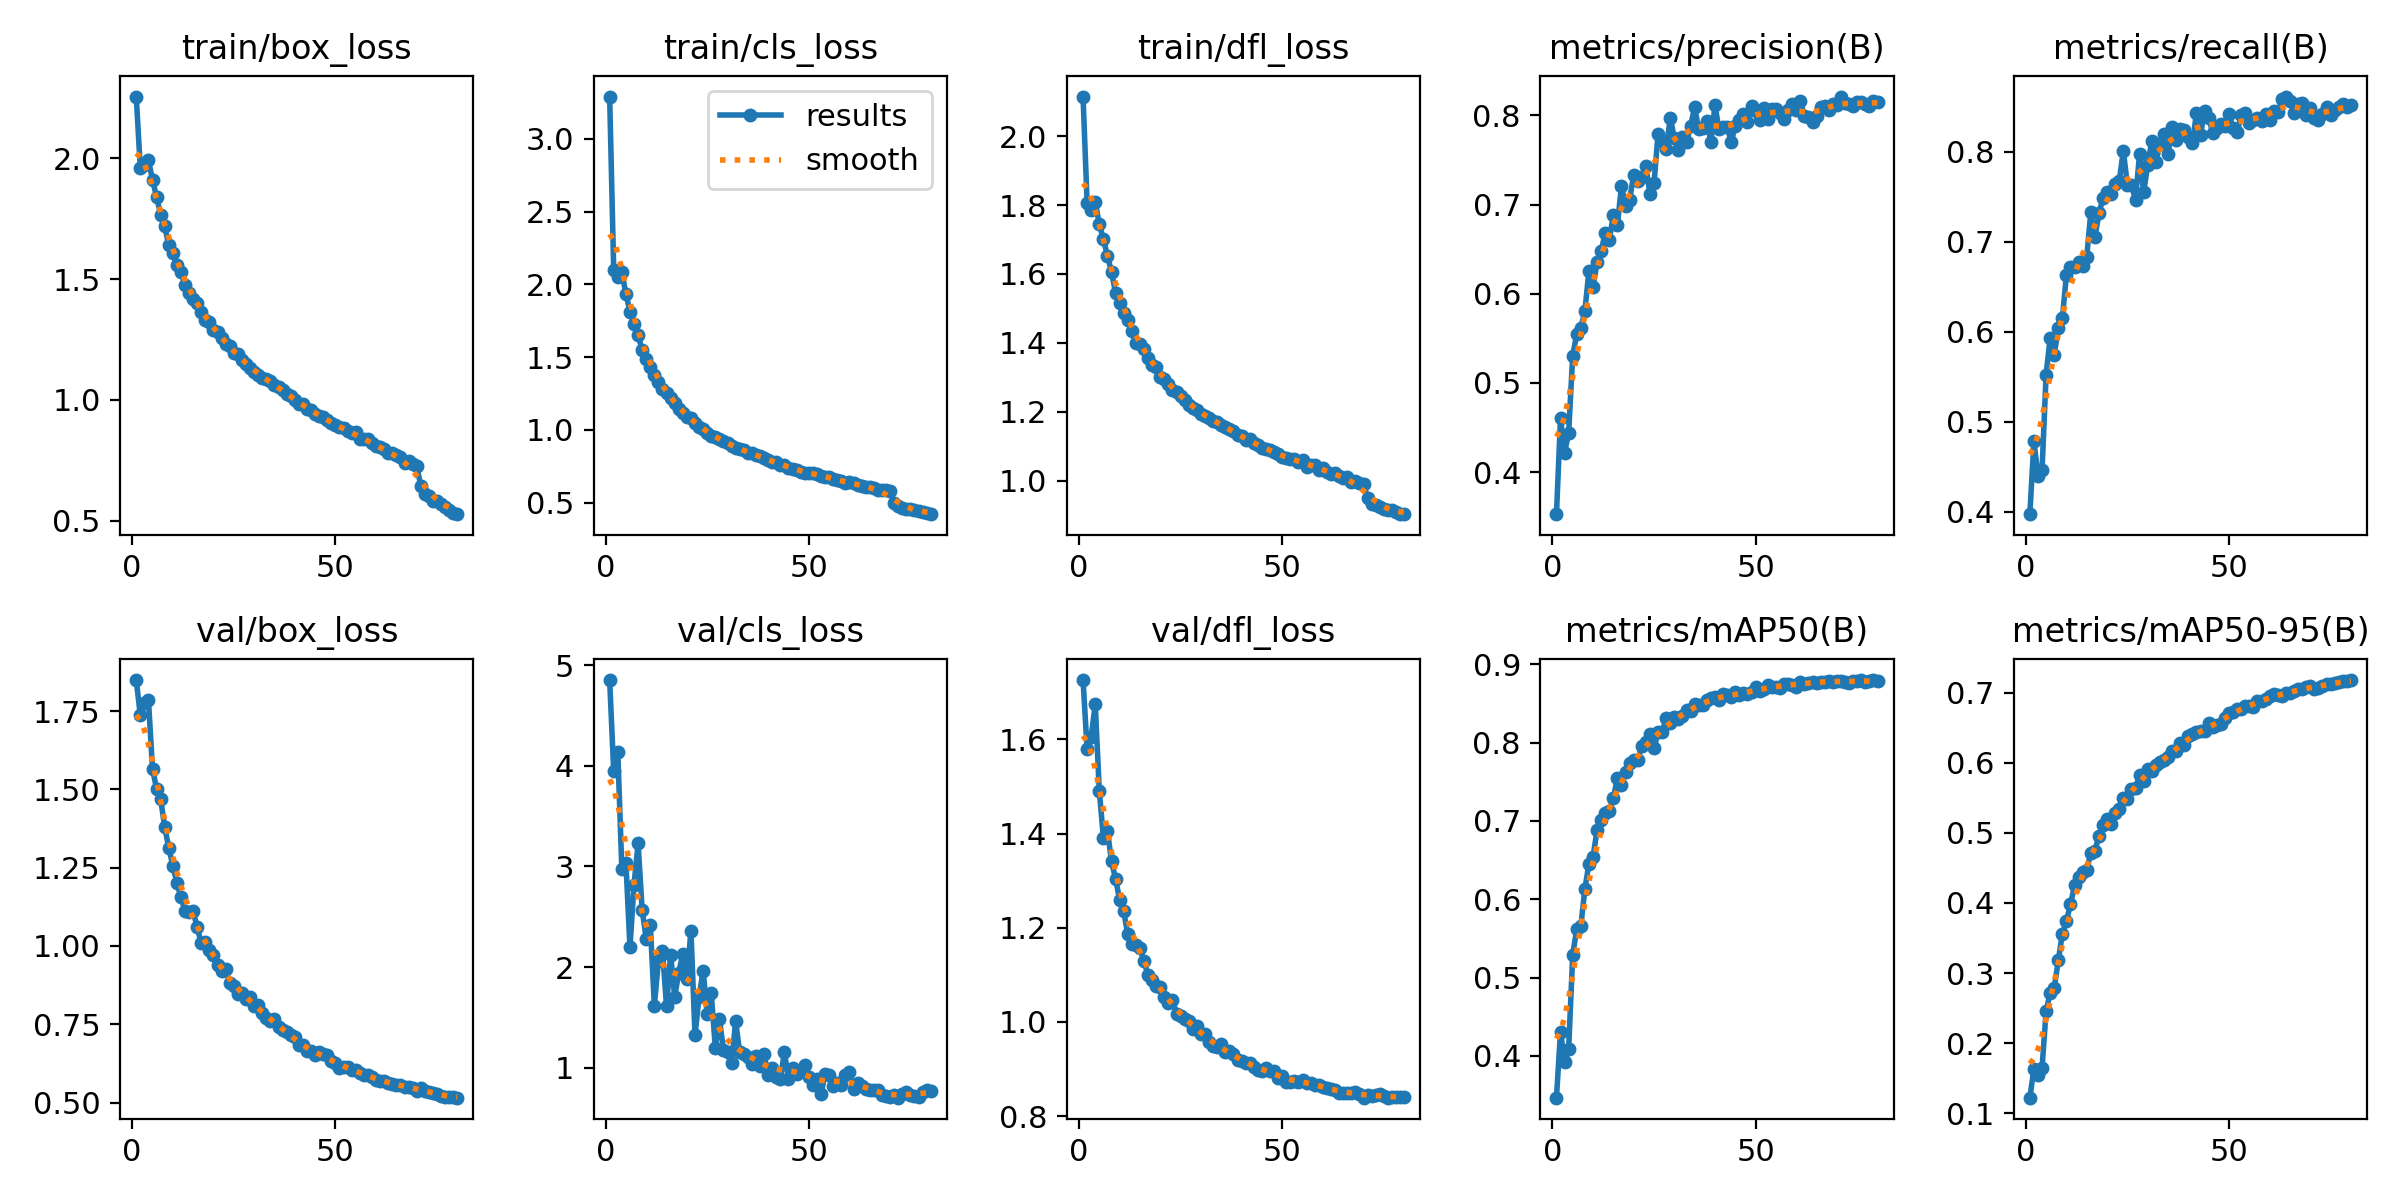

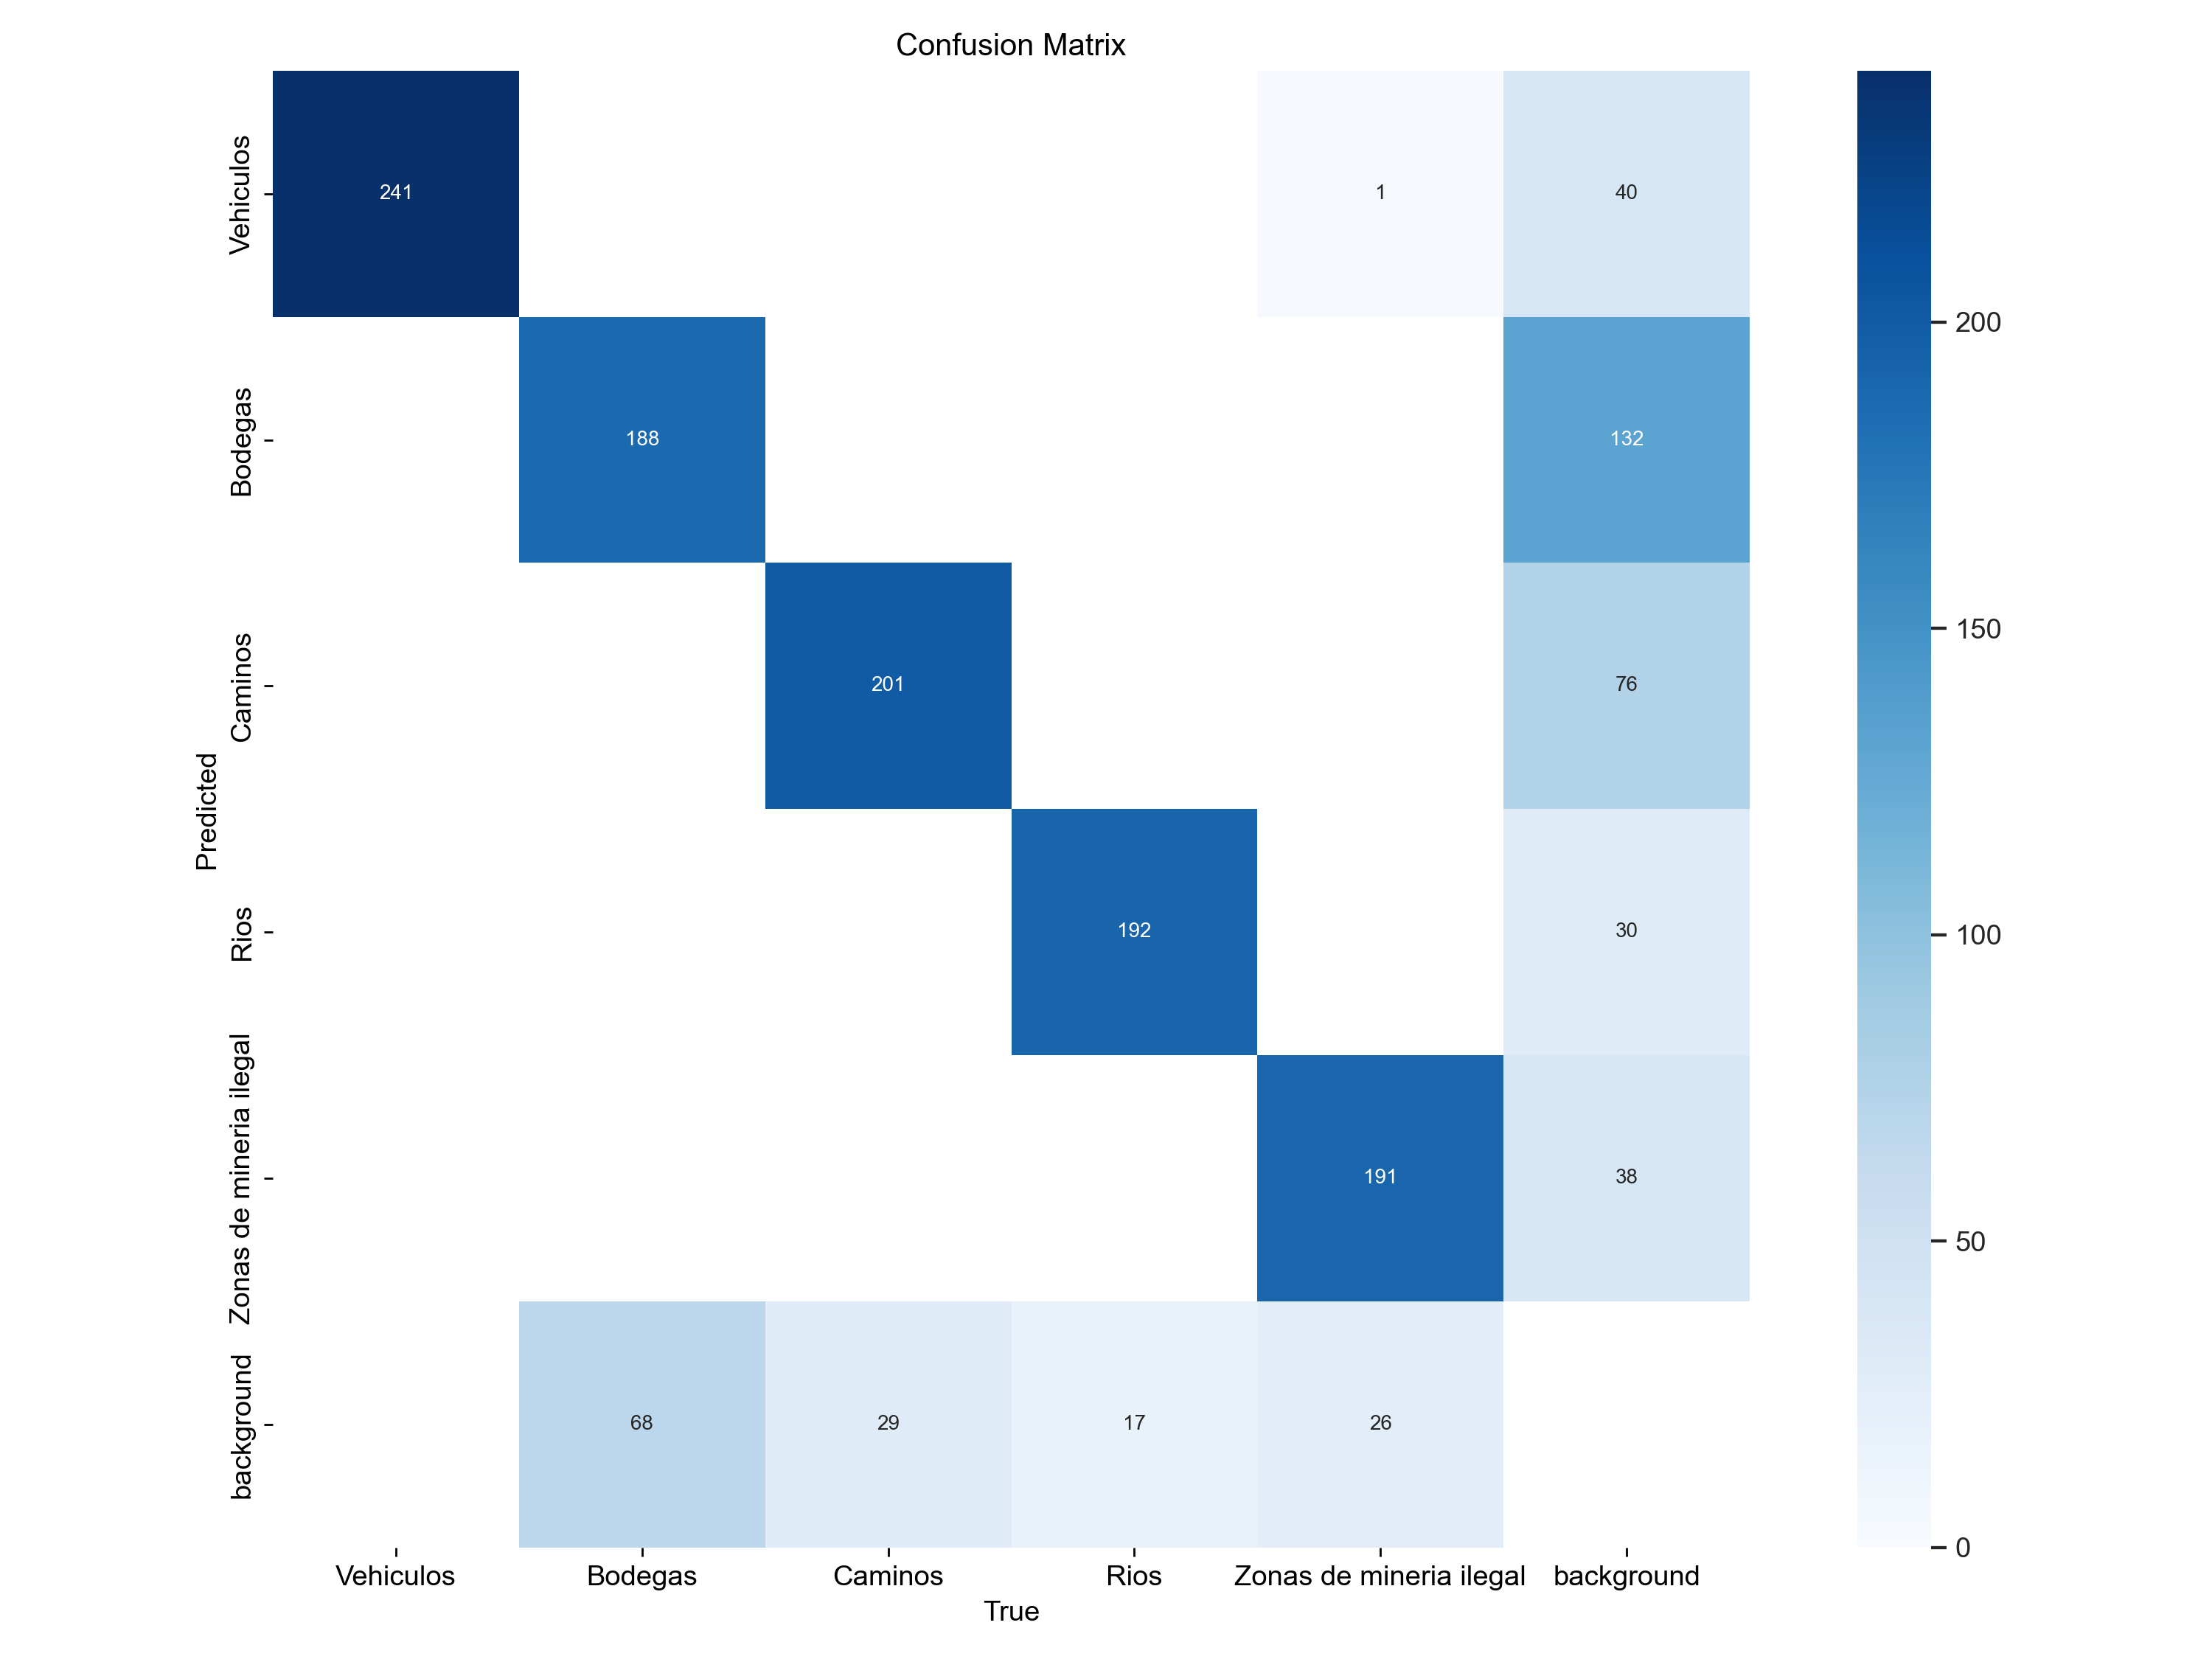

In [11]:
from PIL import Image as PImage
display(PImage.open('runs/detect/modelo_yolov11_dataset_completo_final2/results.png'))

display(PImage.open('runs/detect/modelo_yolov11_dataset_completo_final2/confusion_matrix.png'))

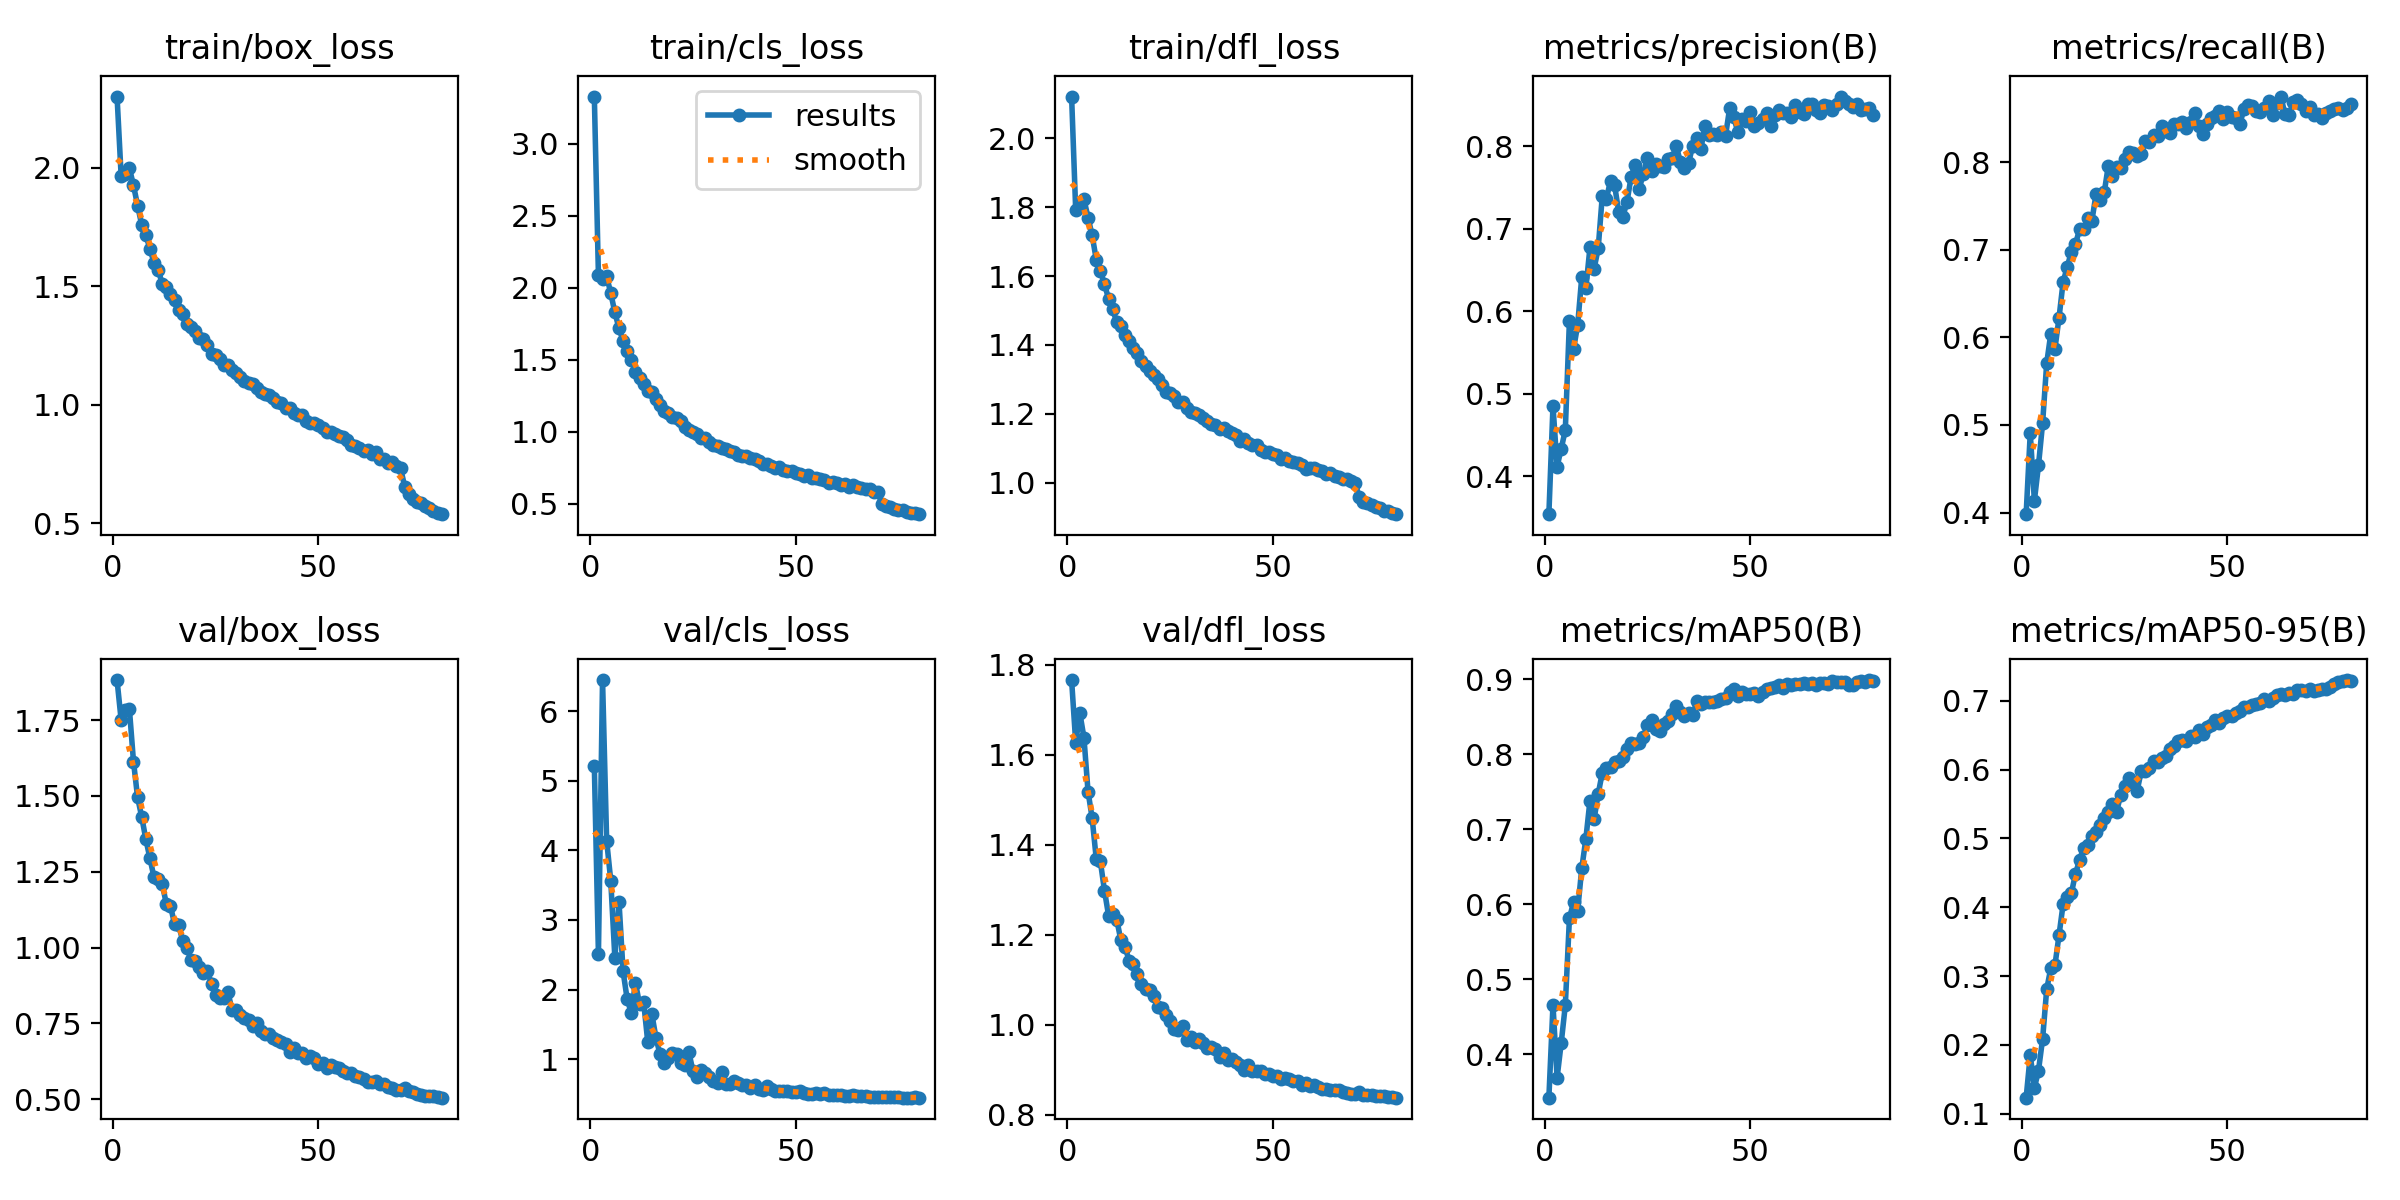

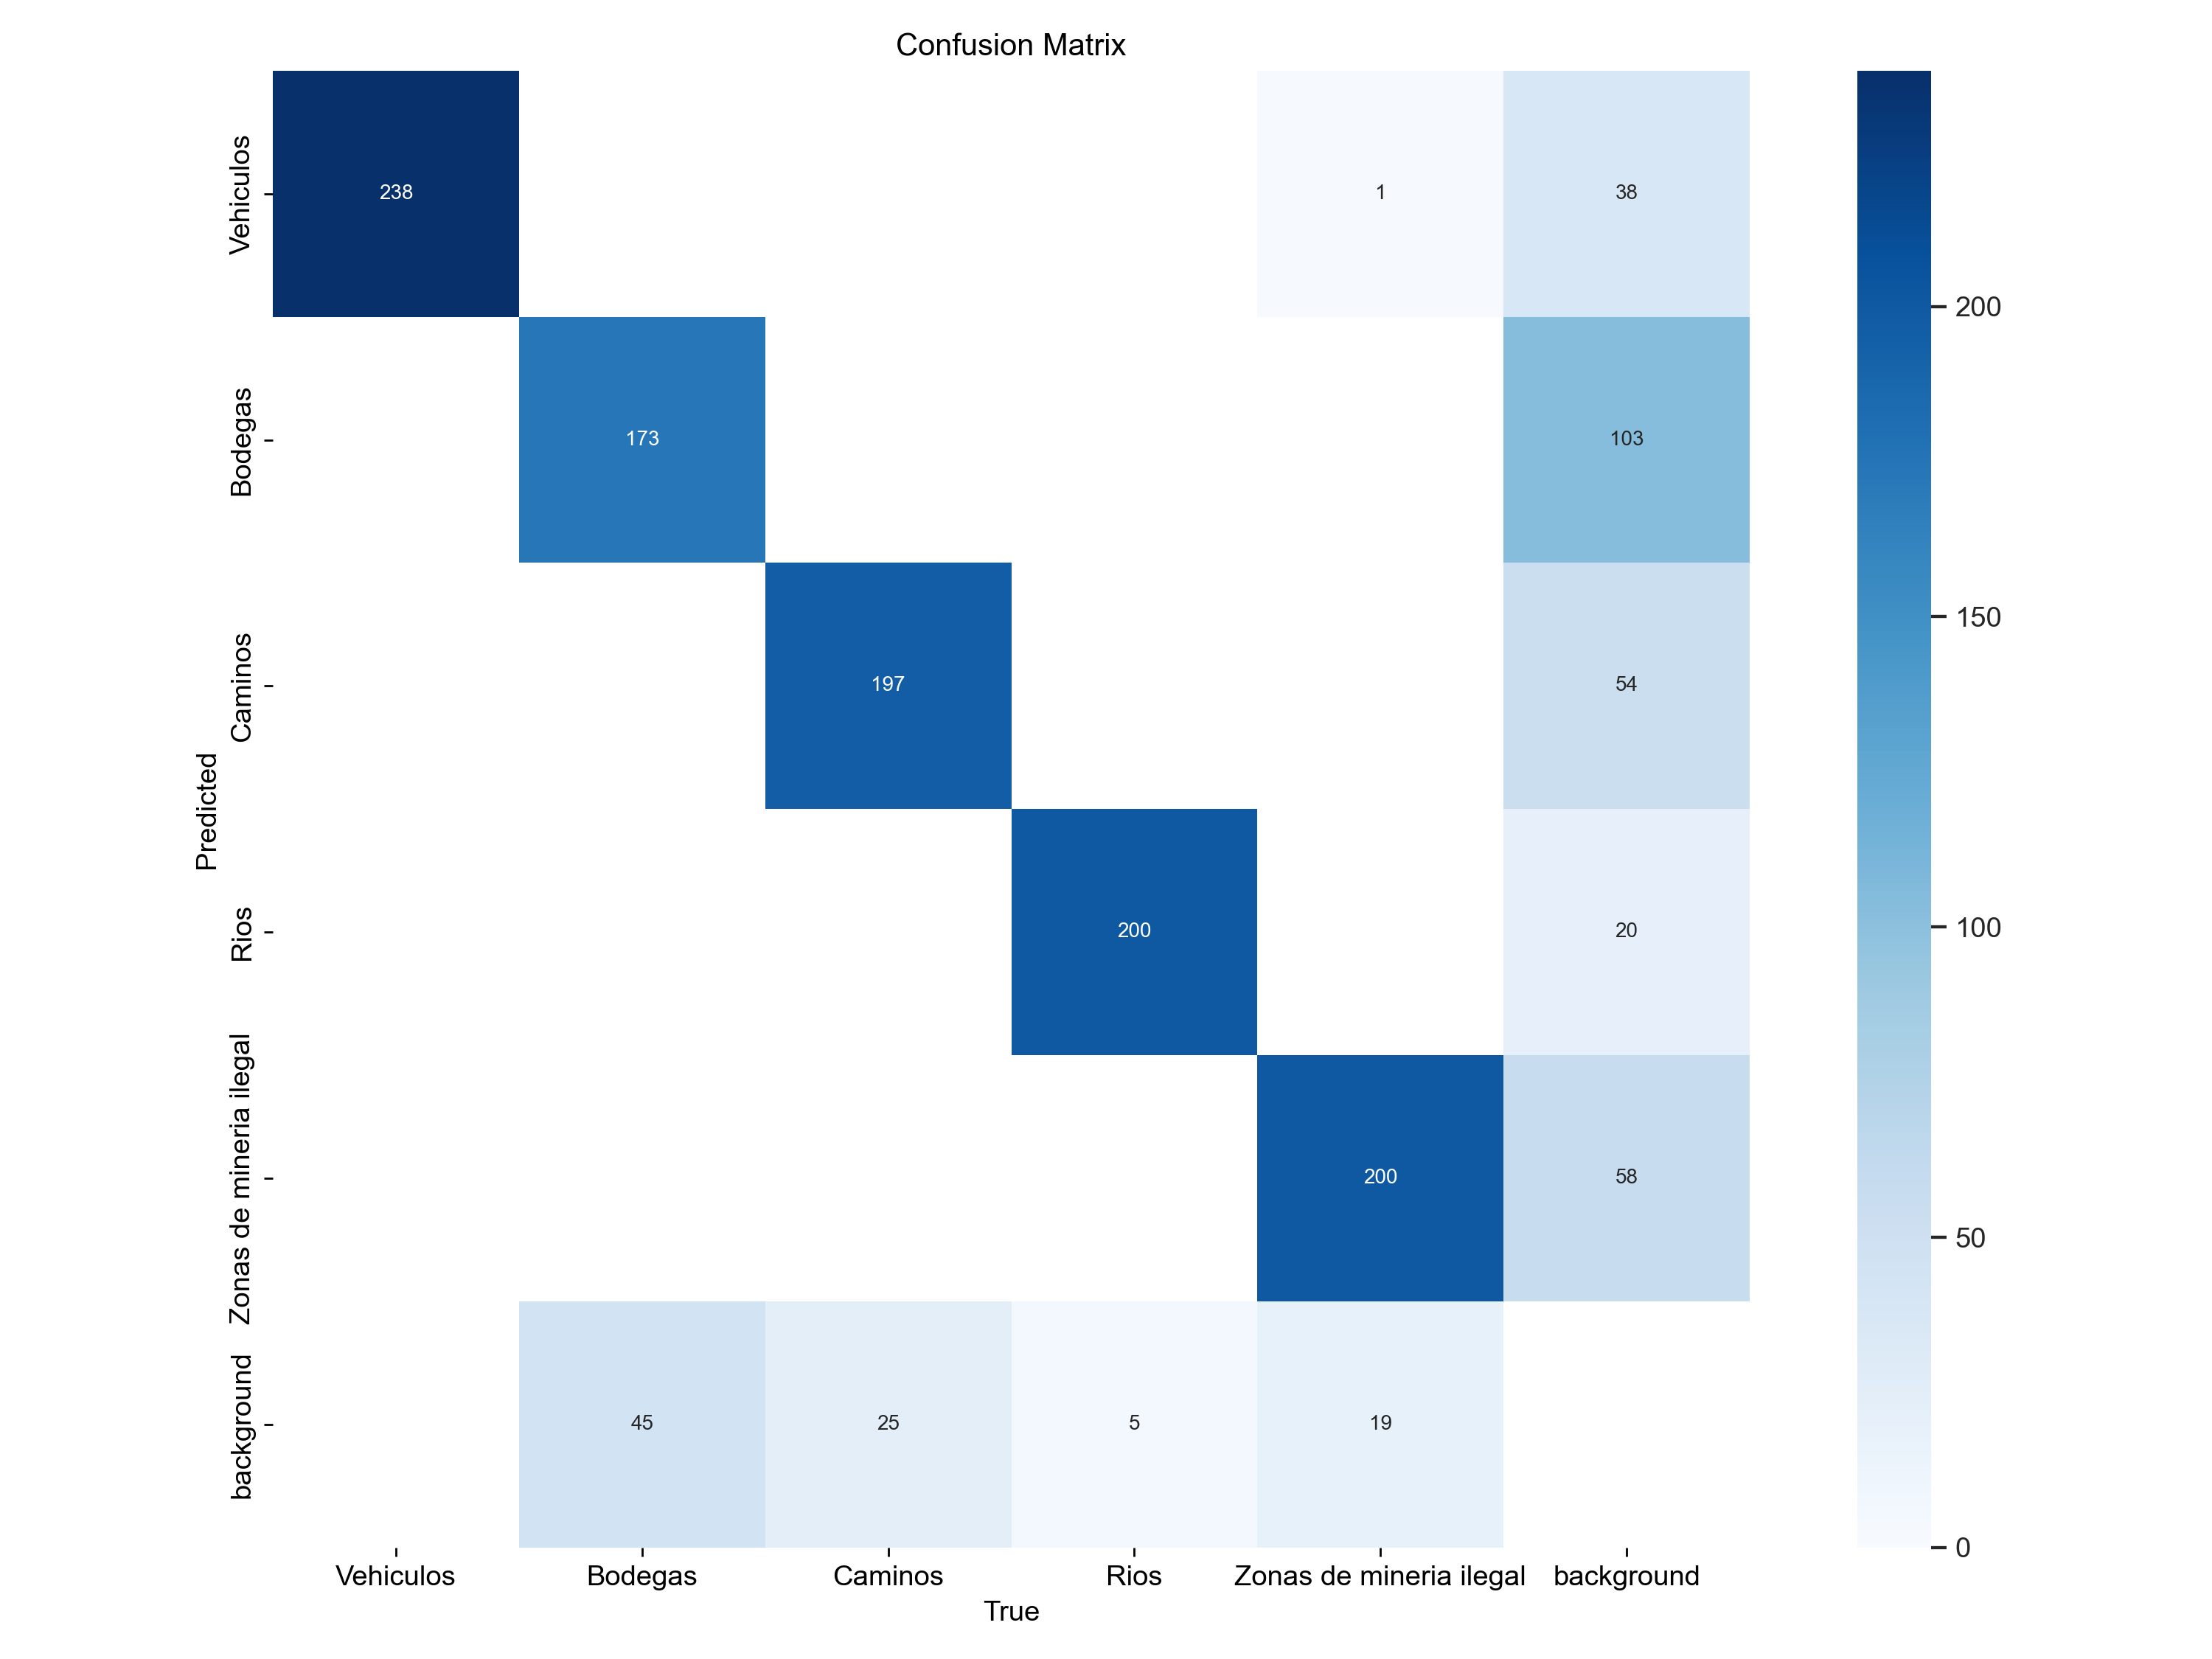

In [12]:
from PIL import Image as PImage
display(PImage.open('runs/detect/modelo_yolov11_dataset_filtrado_final3/results.png'))

display(PImage.open('runs/detect/modelo_yolov11_dataset_filtrado_final3/confusion_matrix.png'))

# Finetuning

In [20]:
def finetune_yolo_model(
    model_path,
    dataset_yaml_path,
    save_dir,
    run_name,
    lr=0.0005,
    epochs=15,
    imgsz=640,
    batch=16,
):
    """
    Fine-tunes only the detection head of a YOLOv8 model (freezing the backbone).
    
    Args:
        model_path (str): Path to the pre-trained YOLO model (.pt).
        dataset_yaml_path (str): Path to the dataset YAML file.
        save_dir (str): Base directory to save the run.
        run_name (str): Name of the training run.
        lr (float): Initial learning rate (suggested: 1e-4 to 1e-3).
        epochs (int): Number of fine-tuning epochs.
        imgsz (int): Image size for training.
        batch (int): Batch size.
        device (int or str): Device to use ('cpu', 0, 1, etc.).
    """
    assert os.path.exists(model_path), f"Modelo no encontrado: {model_path}"
    assert os.path.exists(dataset_yaml_path), f"YAML no encontrado: {dataset_yaml_path}"
    
    model = YOLO(model_path)

    model.train(
        data=dataset_yaml_path,
        epochs=epochs,
        patience=3,
        lr0=lr,
        imgsz=imgsz,
        batch=batch,
        project=save_dir,
        name=run_name,
        optimizer="Adam",          
        cos_lr=True,             
        verbose=True,
        seed=42,
        deterministic=True,
        single_cls=False,
        rect=False,
        freeze=10                
    )


## Finetuning - filtrado

In [21]:
finetune_yolo_model(
    model_path="runs/detect/modelo_yolov11_dataset_filtrado_final3/weights/best.pt",
    dataset_yaml_path="modelo_yolov11_dataset_filtrado/dataset.yaml",
    save_dir="finetuning_resultados",
    run_name="finetune_filtered=dataset",
)




New https://pypi.org/project/ultralytics/8.3.135 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=runs/detect/modelo_yolov11_dataset_filtrado_final3/weights/best.pt, data=modelo_yolov11_dataset_filtrado/dataset.yaml, epochs=15, time=None, patience=3, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=finetuning_resultados, name=finetune_filtered=dataset2, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, au

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_filtrado\train\labels.cache... 8258 images, 2062 backgrounds, 0 corrupt: 100%|██████████| 8258/8258 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 654.2159.6 MB/s, size: 327.3 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_filtrado\val\labels.cache... 984 images, 237 backgrounds, 0 corrupt: 100%|██████████| 984/984 [00:00<?, ?it/s]


Plotting labels to finetuning_resultados\finetune_filtered=dataset2\labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/15 16:45:11 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/15 16:45:11 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(0a92b8bae1aa4a8e85ef826395877da7) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
WARNING MLflow: Failed to initialize: Changing param values is not allowed. Param with key='patience' was already logged with value='100' for run ID='0a92b8bae1aa4a8e85ef826395877da7'. Attempted logging new value '3'.
WARNING MLflow: Not tracking this run
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to finetuning_resultados\finetune_filtered=dataset2
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      1.98G     0.7881     0.6423      1.019          2        640: 100%|██████████| 517/517 [01:35<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.31it/s]

                   all        984       1103      0.841       0.86      0.891      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      1.98G     0.7784     0.6228       1.02          6        640: 100%|██████████| 517/517 [01:30<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.56it/s]


                   all        984       1103      0.831      0.858      0.889      0.699

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      1.98G      0.787     0.6384      1.027          2        640: 100%|██████████| 517/517 [01:27<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.26it/s]

                   all        984       1103      0.826      0.851      0.881      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      1.98G     0.7817     0.6371      1.028          3        640: 100%|██████████| 517/517 [01:27<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.37it/s]

                   all        984       1103      0.822      0.856      0.881      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      1.98G     0.7715      0.623      1.018          7        640: 100%|██████████| 517/517 [01:27<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.39it/s]

                   all        984       1103      0.826      0.869      0.889      0.696
EarlyStopping: Training stopped early as no improvement observed in last 3 epochs. Best results observed at epoch 2, best model saved as best.pt.
To update EarlyStopping(patience=3) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



5 epochs completed in 0.135 hours.
Optimizer stripped from finetuning_resultados\finetune_filtered=dataset2\weights\last.pt, 22.5MB
Optimizer stripped from finetuning_resultados\finetune_filtered=dataset2\weights\best.pt, 22.5MB

Validating finetuning_resultados\finetune_filtered=dataset2\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.87it/s]


                   all        984       1103      0.831      0.858      0.889      0.699
             Vehiculos        233        238      0.862      0.996      0.942      0.911
               Bodegas         65        218      0.674      0.679      0.713      0.355
               Caminos        134        222      0.811      0.811      0.878      0.587
                  Rios        137        205      0.868      0.956      0.967      0.732
Zonas de mineria ilegal        207        220      0.938       0.85      0.945      0.909
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to finetuning_resultados\finetune_filtered=dataset2
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'


## Finetuning - completo

In [22]:
finetune_yolo_model(
    model_path="runs/detect/modelo_yolov11_dataset_completo_final2/weights/best.pt",
    dataset_yaml_path="modelo_yolov11_dataset_filtrado/dataset.yaml",
    save_dir="finetuning_resultados",
    run_name="fnietune_complete_dataset",
)

New https://pypi.org/project/ultralytics/8.3.135 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=runs/detect/modelo_yolov11_dataset_completo_final2/weights/best.pt, data=modelo_yolov11_dataset_filtrado/dataset.yaml, epochs=15, time=None, patience=3, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=finetuning_resultados, name=fnietune_complete_dataset, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, aug

train: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_filtrado\train\labels.cache... 8258 images, 2062 backgrounds, 0 corrupt: 100%|██████████| 8258/8258 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.2 ms, read: 759.6450.1 MB/s, size: 327.3 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_filtrado\val\labels.cache... 984 images, 237 backgrounds, 0 corrupt: 100%|██████████| 984/984 [00:00<?, ?it/s]


Plotting labels to finetuning_resultados\fnietune_complete_dataset\labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/15 16:54:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/15 16:54:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(a4d0bce2636144ecade9d0f1fa39b08a) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to finetuning_resultados\fnietune_complete_dataset
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      1.83G     0.8727     0.7194      1.063          2        640: 100%|██████████| 517/517 [01:33<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.48it/s]

                   all        984       1103      0.832      0.876       0.91      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      2.02G     0.8586     0.6923      1.061          6        640: 100%|██████████| 517/517 [01:27<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.44it/s]

                   all        984       1103      0.859      0.877      0.909      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      2.02G     0.8702     0.7094      1.072          2        640: 100%|██████████| 517/517 [01:25<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.65it/s]


                   all        984       1103      0.861       0.86      0.917       0.74

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      2.02G     0.8597     0.7007      1.066          3        640: 100%|██████████| 517/517 [01:23<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.53it/s]

                   all        984       1103      0.836      0.874      0.908      0.734
EarlyStopping: Training stopped early as no improvement observed in last 3 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=3) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



4 epochs completed in 0.106 hours.
Optimizer stripped from finetuning_resultados\fnietune_complete_dataset\weights\last.pt, 22.5MB
Optimizer stripped from finetuning_resultados\fnietune_complete_dataset\weights\best.pt, 22.5MB

Validating finetuning_resultados\fnietune_complete_dataset\weights\best.pt...
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:07<00:00,  4.08it/s]


                   all        984       1103      0.832      0.877       0.91      0.749
             Vehiculos        233        238      0.863          1       0.94      0.914
               Bodegas         65        218      0.707      0.743      0.799      0.505
               Caminos        134        222      0.816      0.824       0.88      0.621
                  Rios        137        205      0.859      0.953      0.973      0.767
Zonas de mineria ilegal        207        220      0.916      0.864      0.959      0.936
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to finetuning_resultados\fnietune_complete_dataset
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'


# Resultados Finetuning

## Filtrado

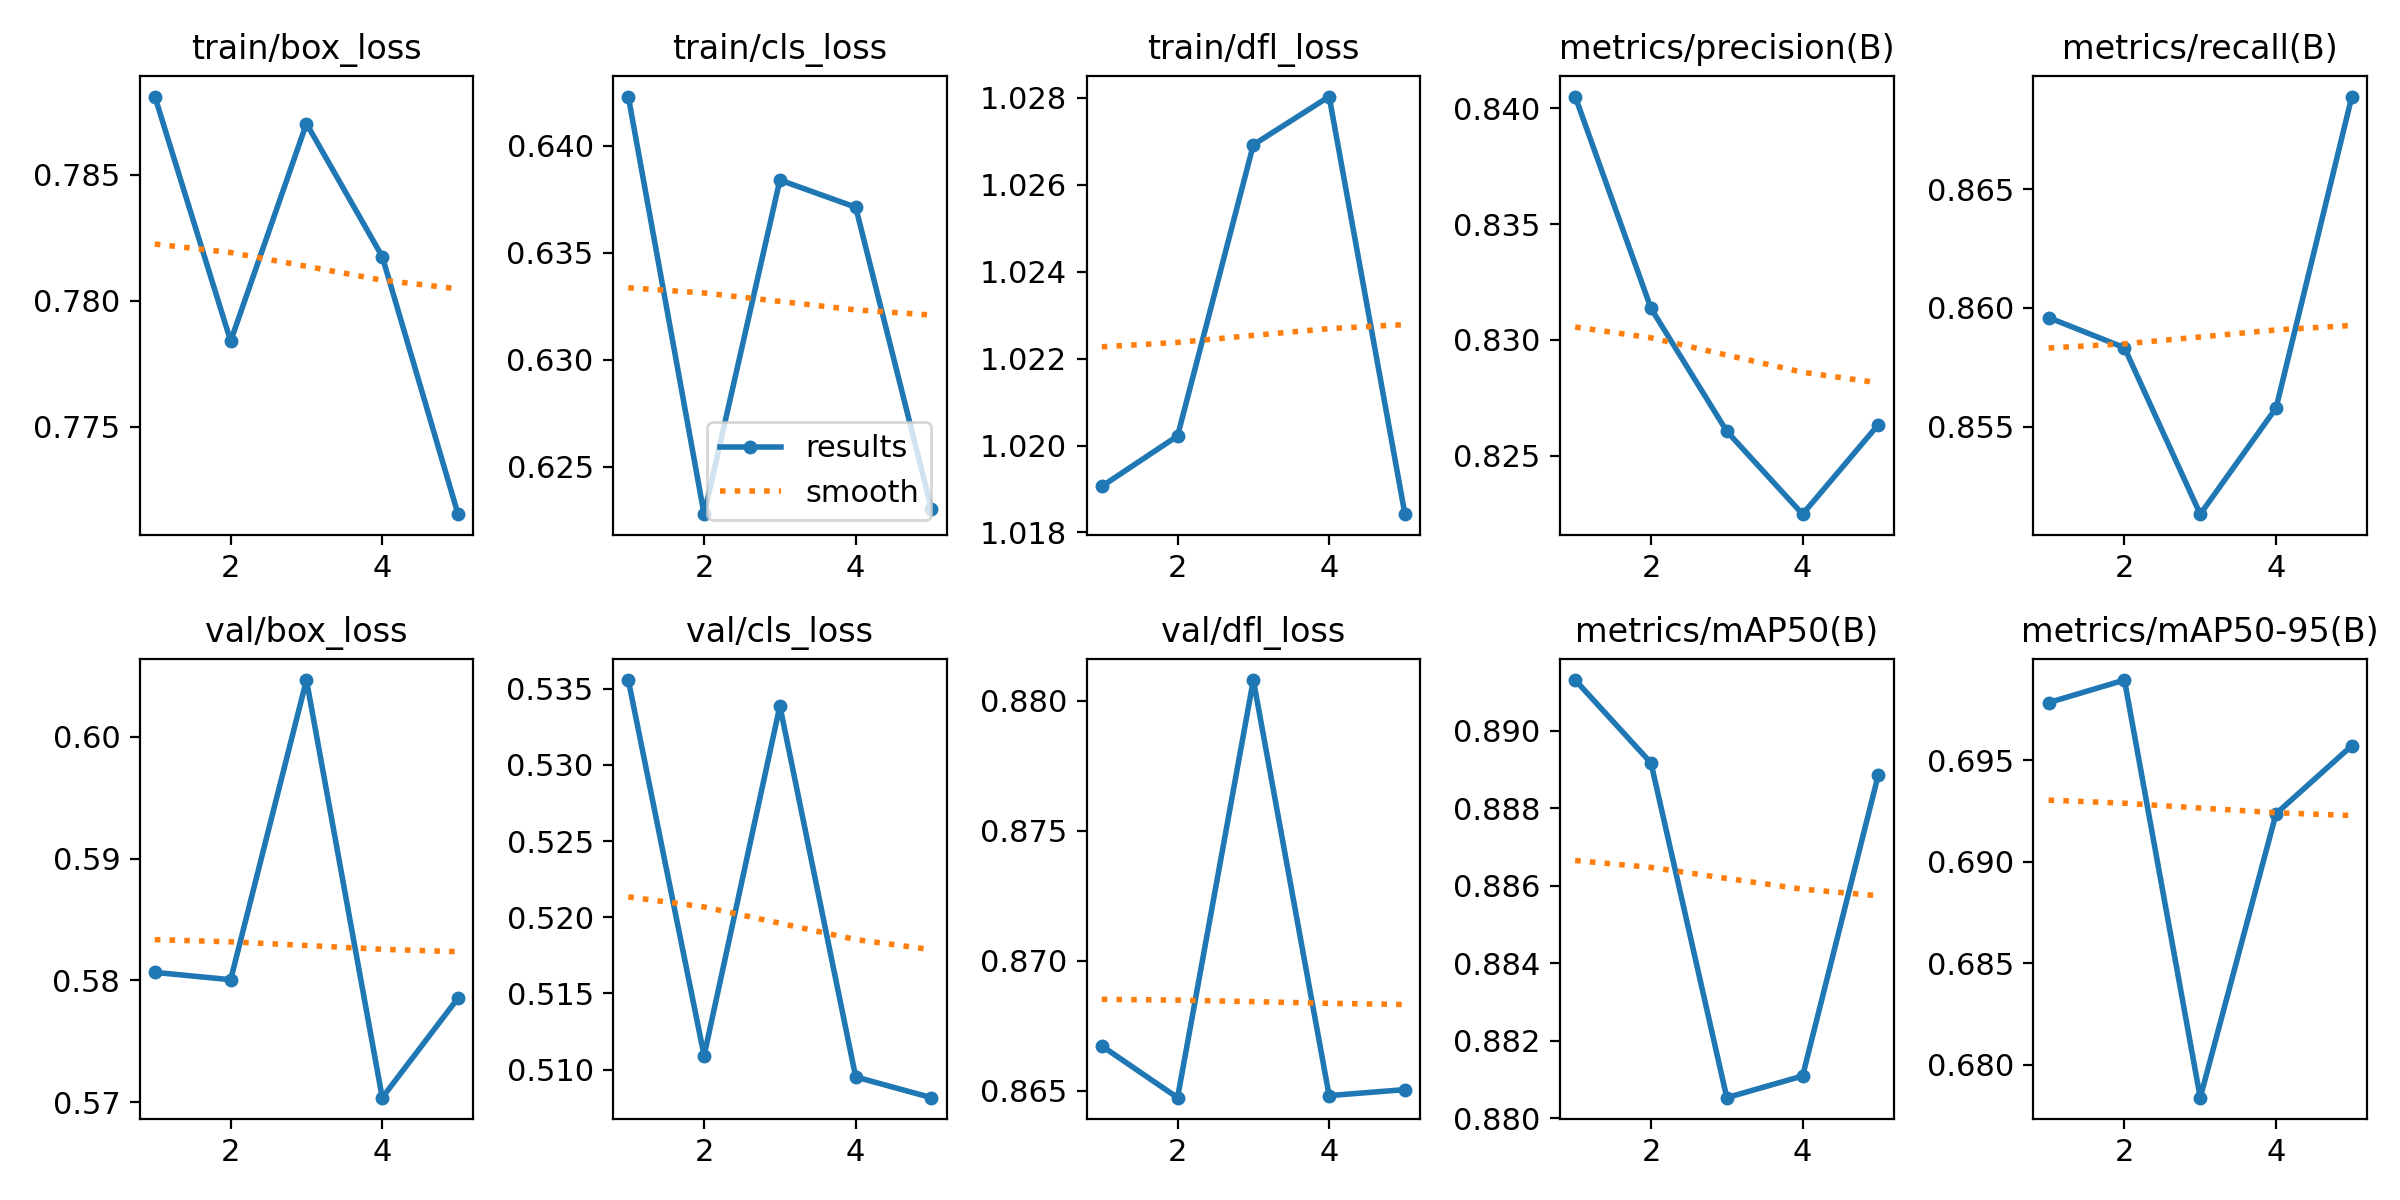

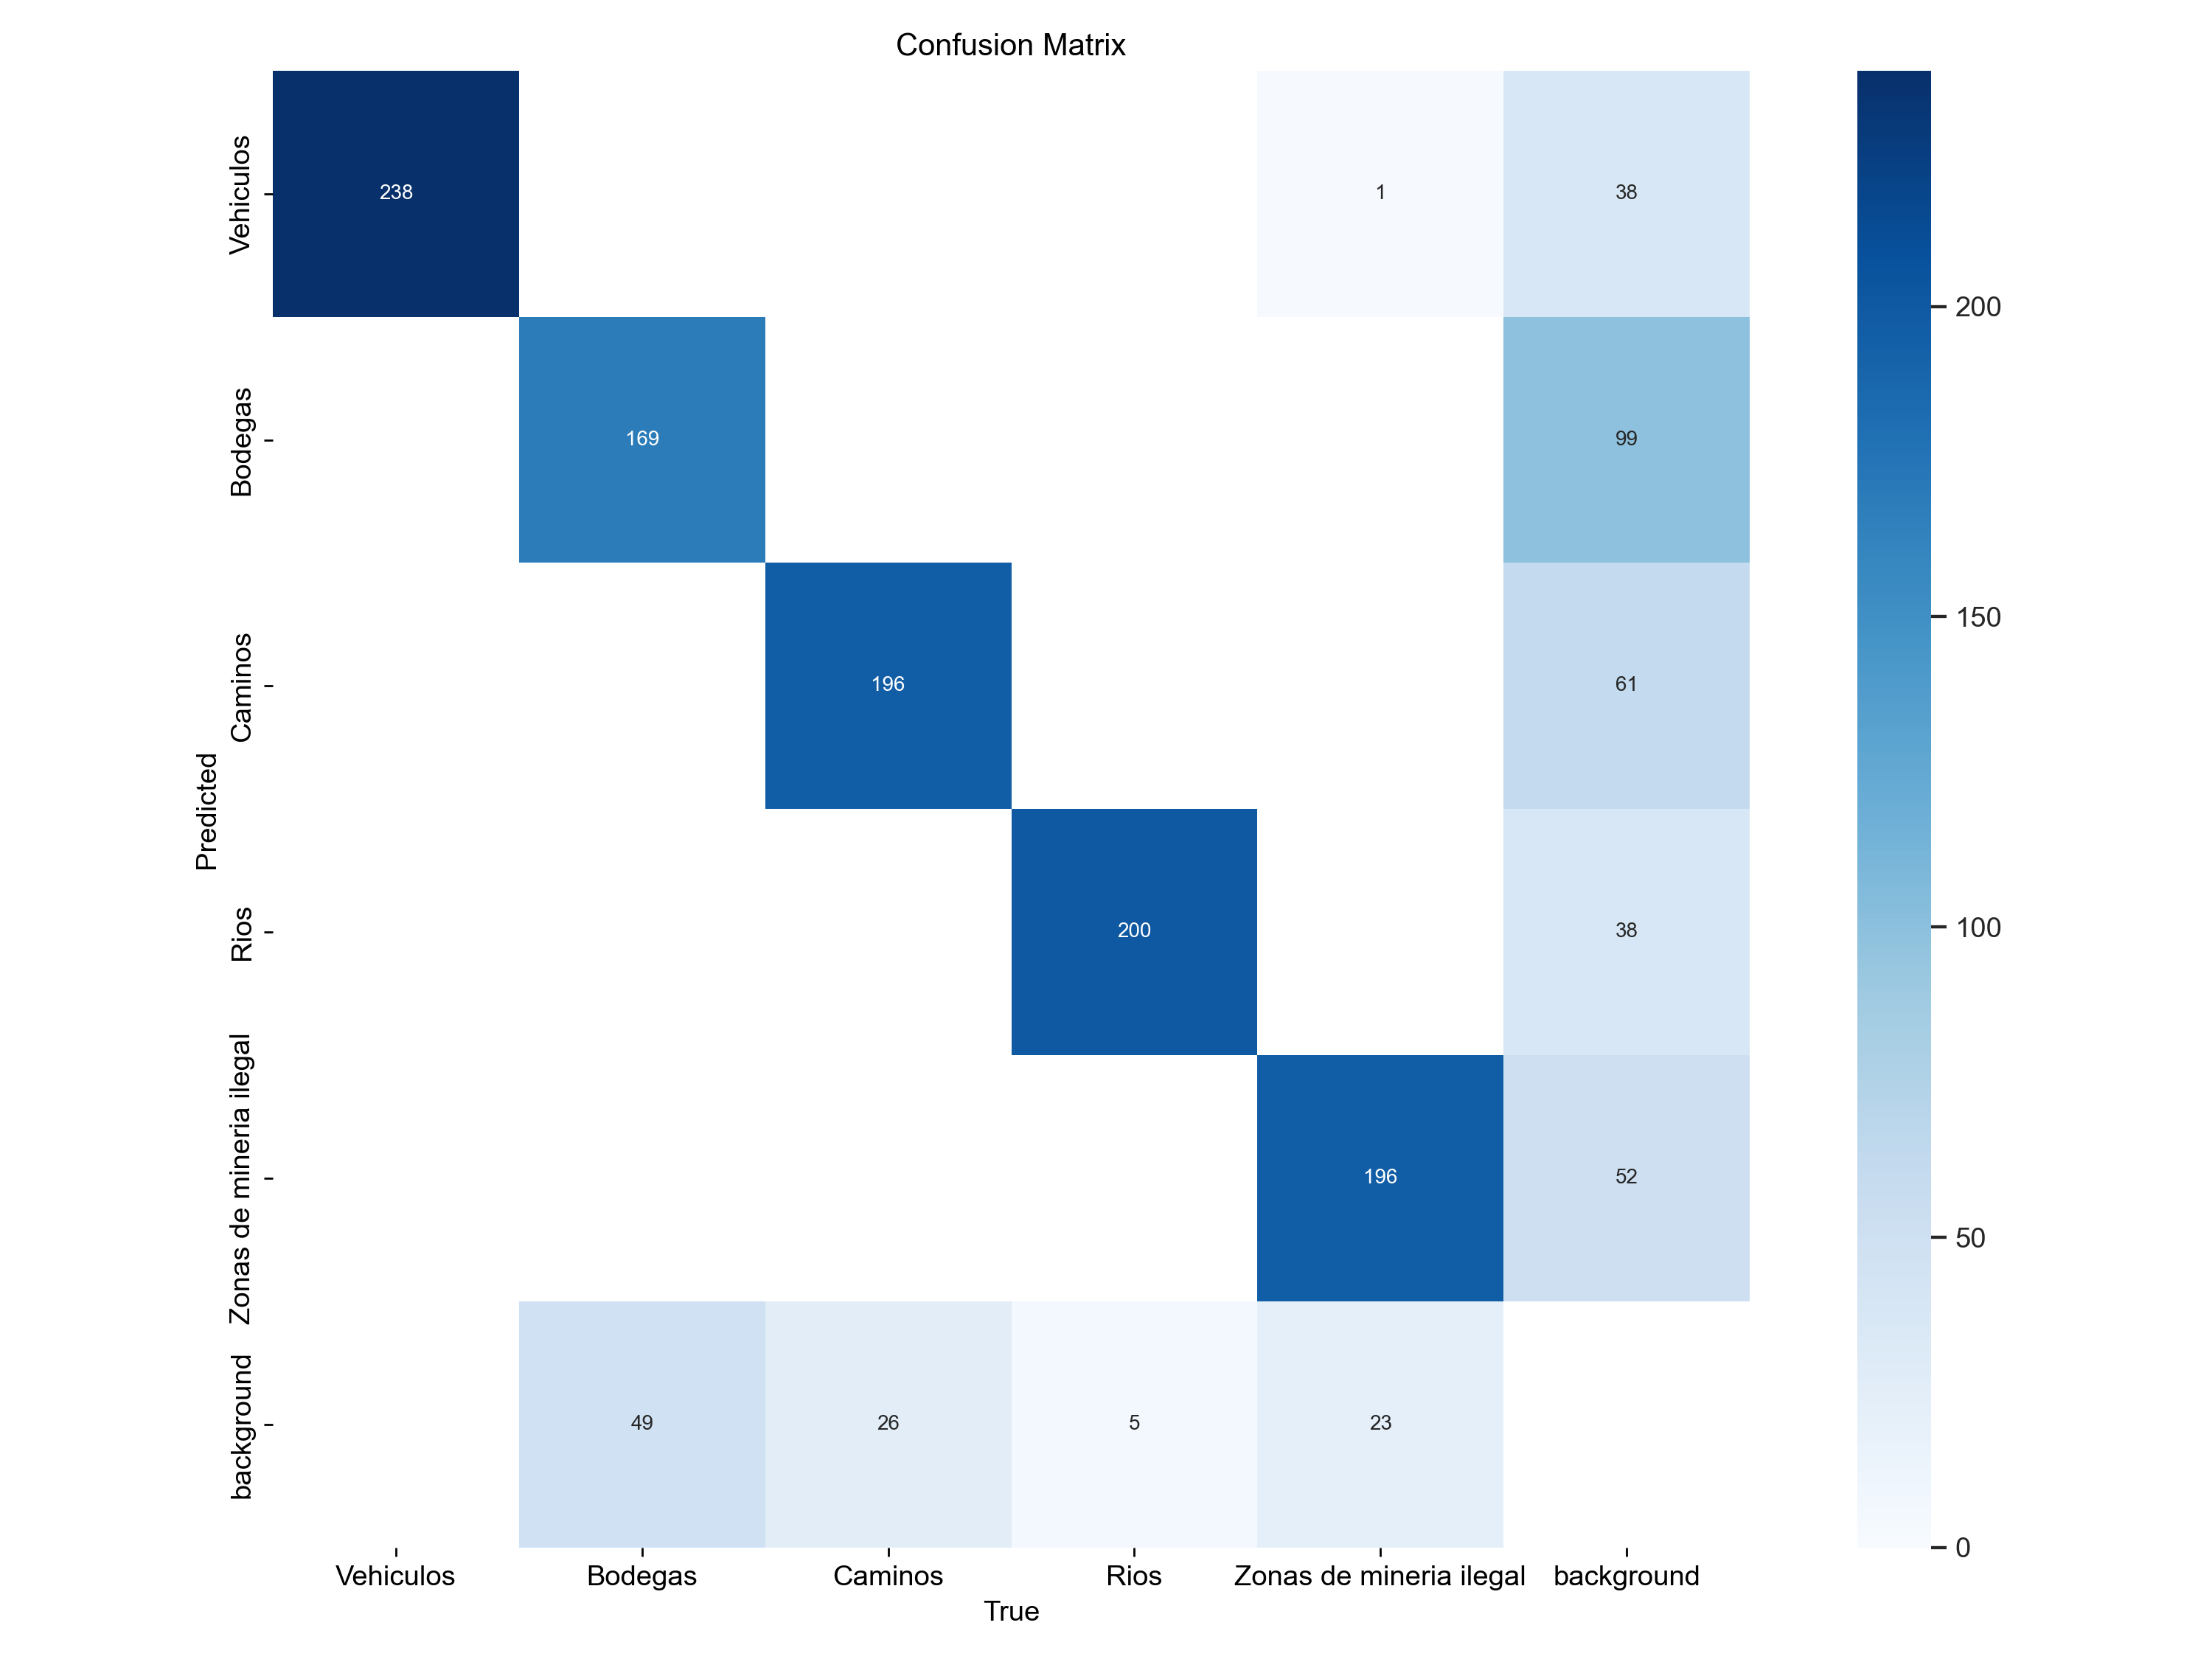

In [26]:
from PIL import Image as PImage
display(PImage.open('finetuning_resultados/finetune_filtered=dataset2/results.png'))

display(PImage.open('finetuning_resultados/finetune_filtered=dataset2/confusion_matrix.png'))

## Completo

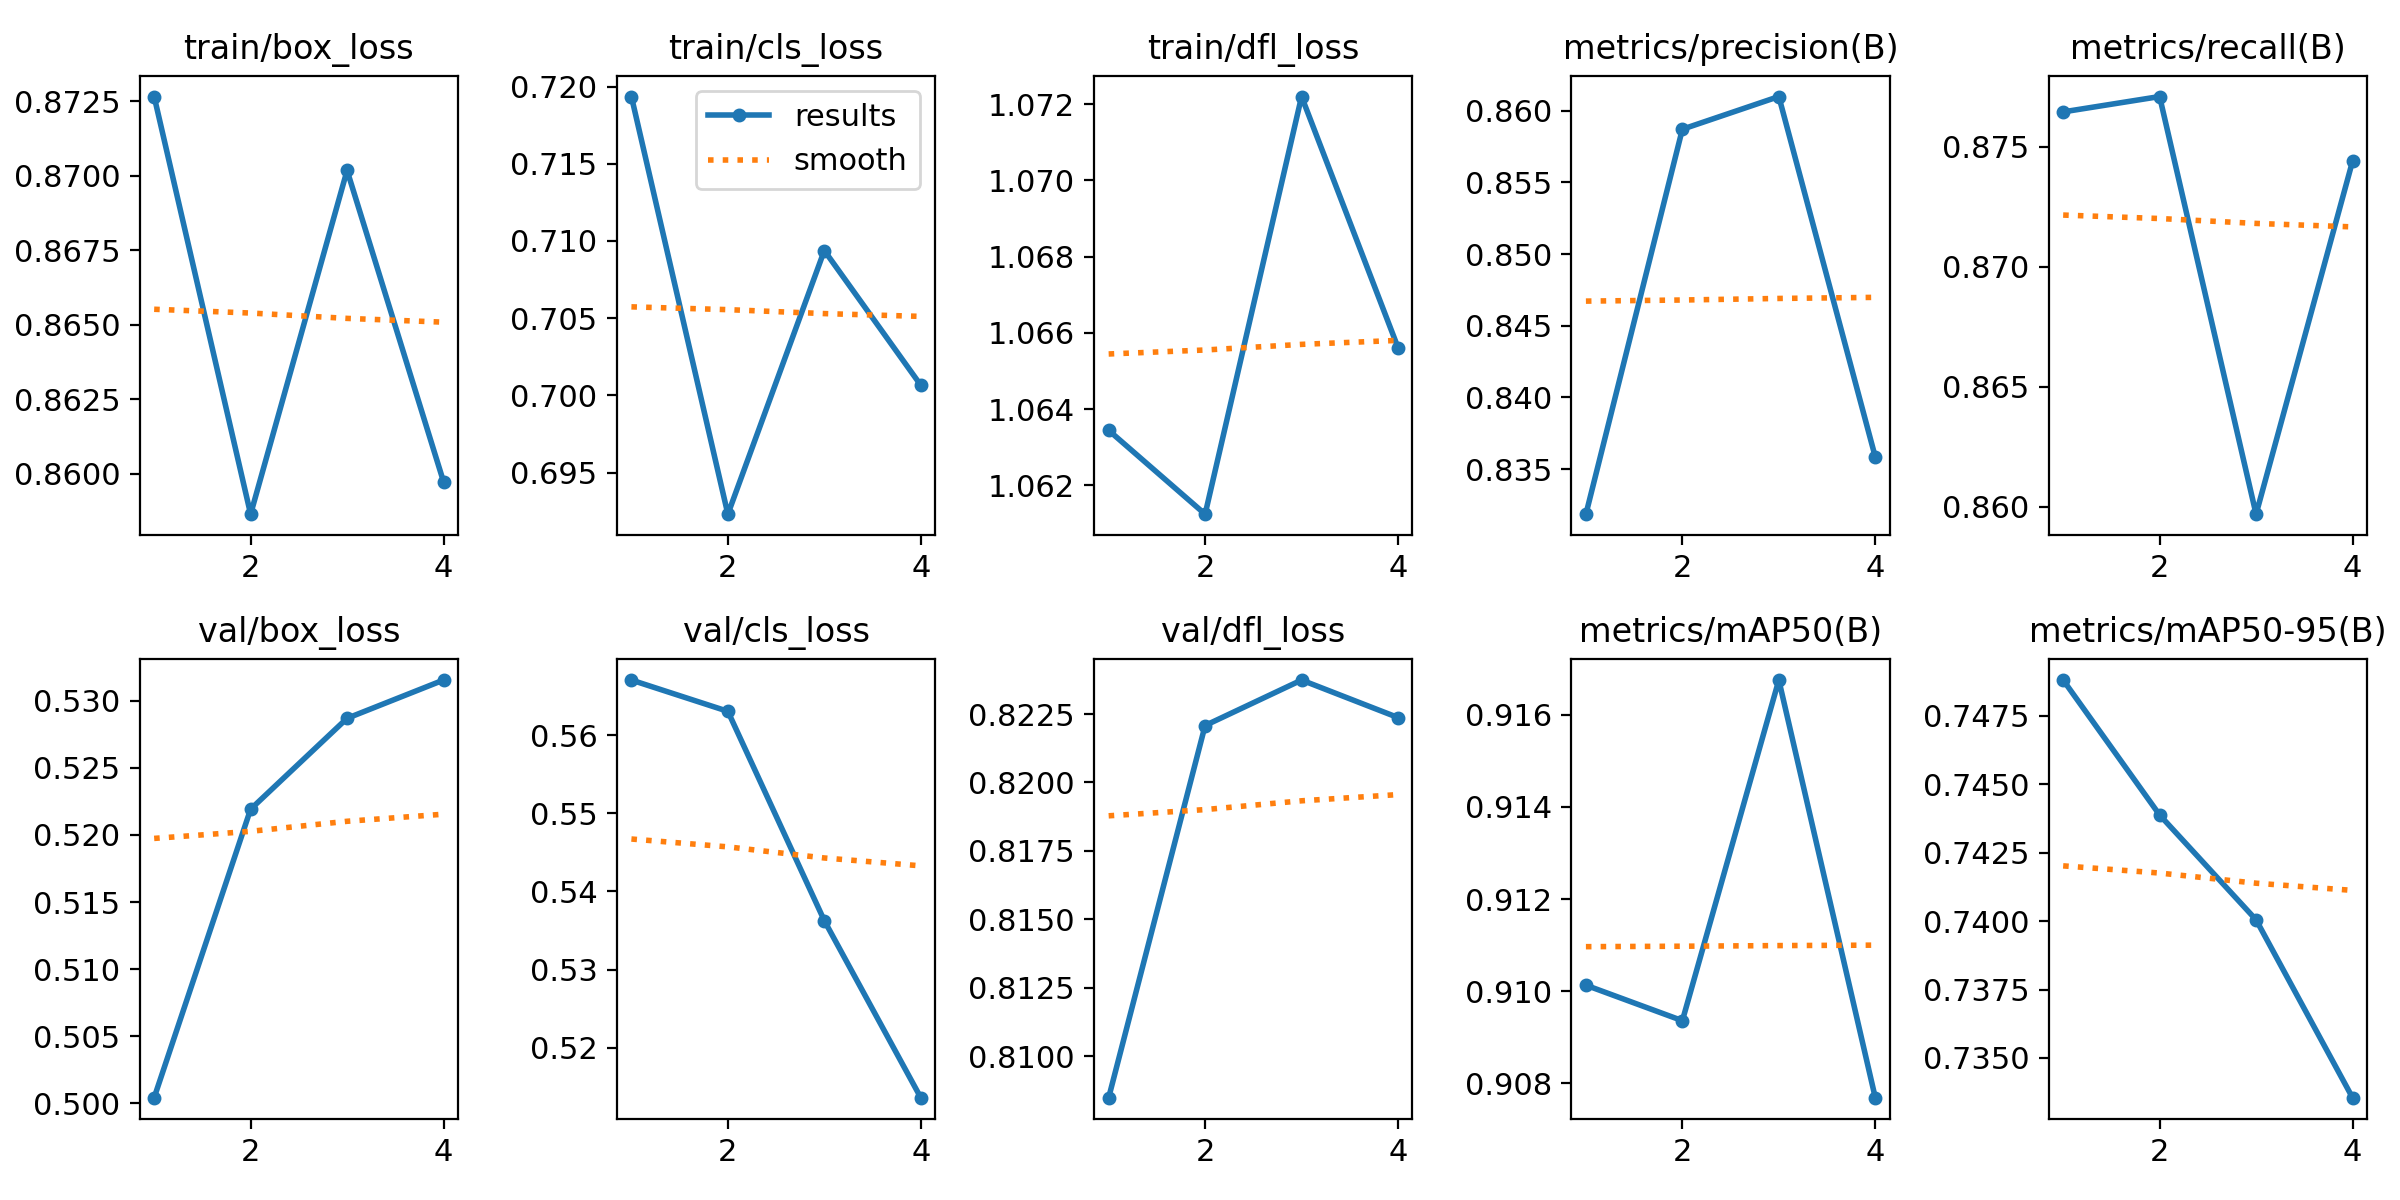

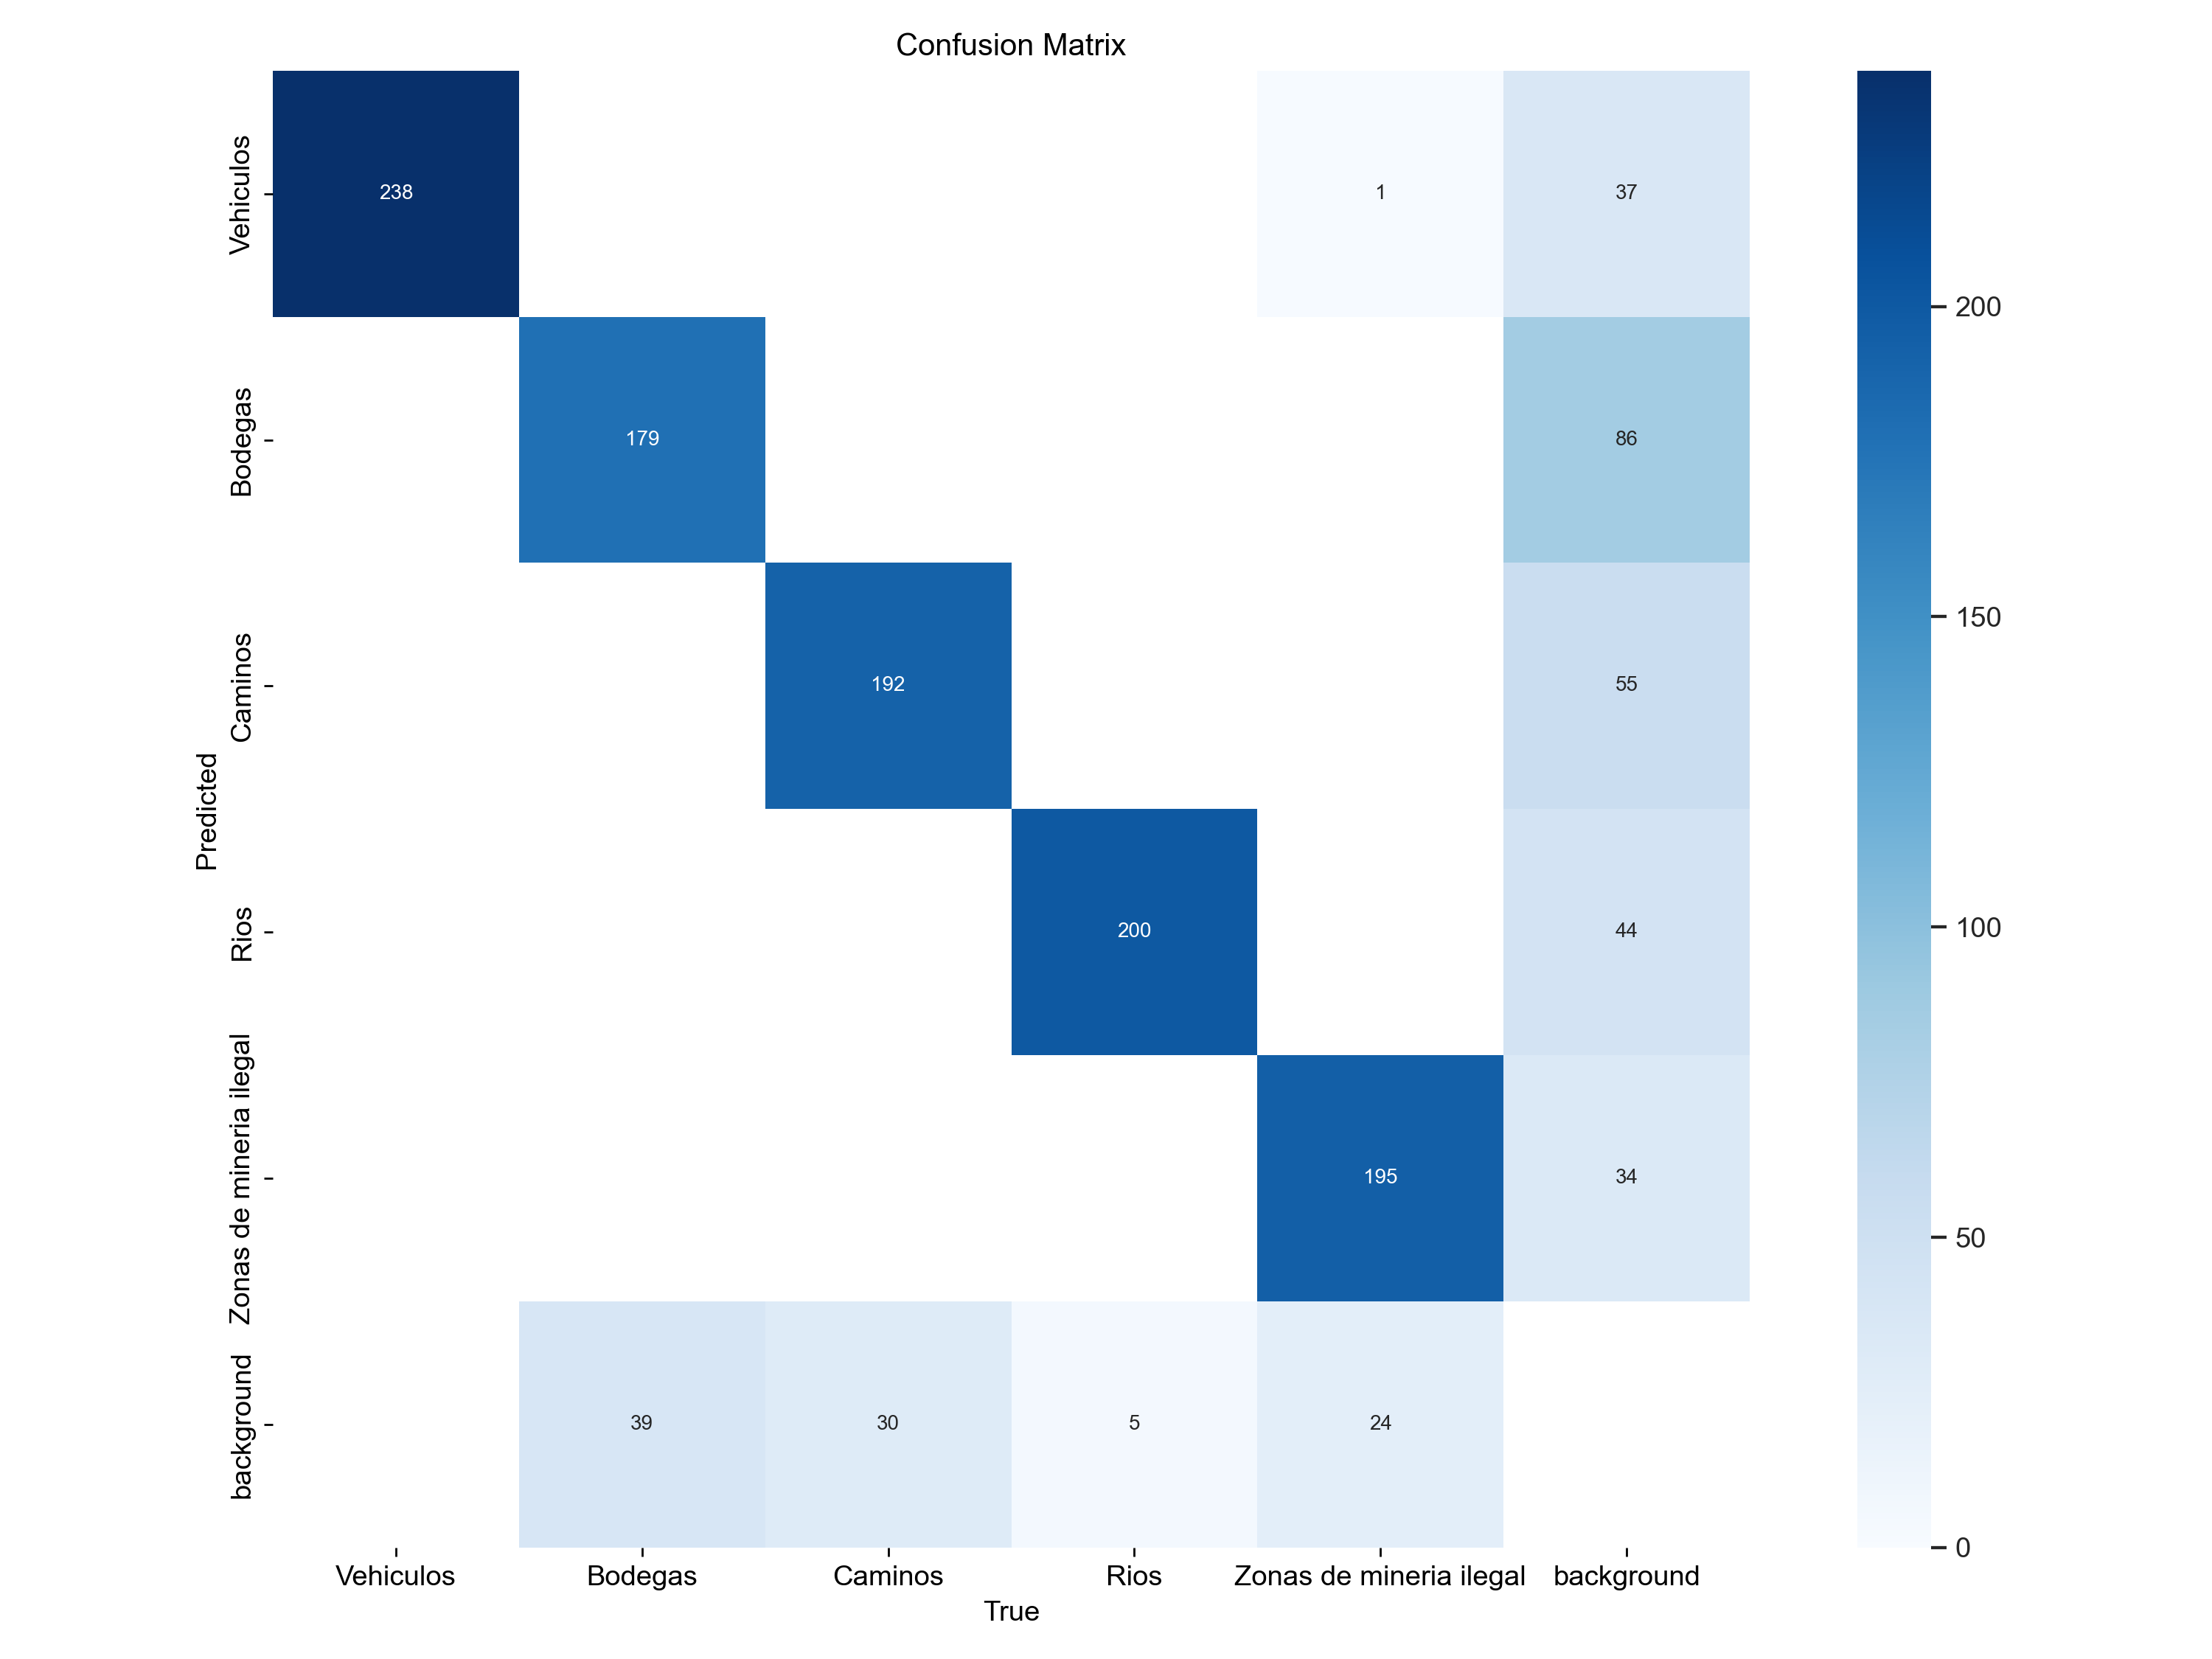

In [24]:
from PIL import Image as PImage
display(PImage.open('finetuning_resultados/fnietune_complete_dataset/results.png'))

display(PImage.open('finetuning_resultados/fnietune_complete_dataset/confusion_matrix.png'))

# Metricas

In [49]:
from ultralytics import YOLO
import os

def evaluate_yolo_model(model_path, dataset_yaml_path, split='test', imgsz=640, device=0):
    """
    Evalúa un modelo YOLOv8 y retorna mAP@50, mAP@50-95, precision y recall.
    """
    assert os.path.exists(model_path), f"Modelo no encontrado: {model_path}"
    assert os.path.exists(dataset_yaml_path), f"YAML no encontrado: {dataset_yaml_path}"

    model = YOLO(model_path)

    metrics = model.val(
        data=dataset_yaml_path,
        split=split,
        imgsz=imgsz,
        device=device,
        iou=0.5,
        verbose=True
    )

    return metrics


In [51]:
results_filtrado = evaluate_yolo_model(
    model_path="finetuning_resultados/finetune_filtered=dataset2/weights/best.pt",
    dataset_yaml_path="modelo_yolov11_dataset_filtrado/dataset.yaml"
)

results_completo = evaluate_yolo_model(
    model_path="finetuning_resultados/fnietune_complete_dataset/weights/best.pt",
    dataset_yaml_path="modelo_yolov11_dataset_completo/dataset.yaml"
)

print("📊 Resultados - Dataset Filtrado")
print(results_filtrado)

print("\n📊 Resultados - Dataset Completo")
print(results_completo)


Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.20.1 ms, read: 634.8318.7 MB/s, size: 317.9 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_filtrado\test\labels.cache... 2416 images, 615 backgrounds, 0 corrupt: 100%|██████████| 2416/2416 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 151/151 [00:24<00:00,  6.27it/s]


                   all       2416       2712      0.803      0.867      0.874        0.7
             Vehiculos        465        472      0.839      0.998      0.946      0.915
               Bodegas        157        515      0.625      0.695      0.659      0.331
               Caminos        353        591       0.75      0.841      0.871      0.602
                  Rios        348        561      0.879      0.934       0.94      0.732
Zonas de mineria ilegal        537        573      0.925      0.867      0.955       0.92
Speed: 0.1ms preprocess, 3.6ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\val9
Ultralytics 8.3.121  Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.60.2 ms, read: 26.915.6 MB/s, size: 373.0 KB)


val: Scanning E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_completo\test\labels... 2424 images, 617 backgrounds, 0 corrupt: 100%|██████████| 2424/2424 [00:07<00:00, 329.15it/s]


val: New cache created: E:\Andes\11\Imagenes\FLIR_GPF2\modelo_yolov11_dataset_completo\test\labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:24<00:00,  6.12it/s]


                   all       2424       2764      0.796      0.841      0.869      0.703
             Vehiculos        475        489      0.851          1      0.946      0.923
               Bodegas        164        561      0.574      0.586      0.632      0.327
               Caminos        346        572      0.798      0.821      0.875      0.604
                  Rios        358        578      0.837      0.922      0.934      0.732
Zonas de mineria ilegal        530        564      0.922      0.874      0.959       0.93
Speed: 0.1ms preprocess, 4.0ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\val10
📊 Resultados - Dataset Filtrado
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001EBD2A61990>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 

Escogemos el complete model porque funciona mejor para zonas de mineria ilegal

In [61]:
import os
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO
import cv2

def show_predictions_minery_zone(model_path, dataset_path, class_index=4, count=25, imgsz=640, device=0):
    """
    Muestra un grid 5x5 con predicciones sobre imágenes que contienen la clase 'zonas de minería ilegal'.

    Args:
        model_path (str): Ruta al modelo YOLO entrenado (.pt).
        dataset_path (str): Ruta a la carpeta raíz del dataset (donde está /test/images y /test/labels).
        class_index (int): Índice de la clase "Zonas de minería ilegal".
        count (int): Número de imágenes a mostrar.
    """
    model = YOLO(model_path)

    labels_dir = os.path.join(dataset_path, 'test', 'labels')
    images_dir = os.path.join(dataset_path, 'test', 'images')

    matching_files = []
    for file in os.listdir(labels_dir):
        label_path = os.path.join(labels_dir, file)
        with open(label_path, 'r') as f:
            lines = f.readlines()
            if any(int(line.split()[0]) == class_index for line in lines):
                matching_files.append(file.replace('.txt', '.jpg'))

    selected_images = random.sample(matching_files, min(count, len(matching_files)))

    fig, axes = plt.subplots(5, 5, figsize=(18, 18))
    fig.suptitle("Predicciones sobre zonas de minería ilegal", fontsize=20)

    for ax, img_name in zip(axes.flat, selected_images):
        img_path = os.path.join(images_dir, img_name)
        results = model(img_path, imgsz=imgsz, device=device, verbose=False)
        pred_img = results[0].plot()

        # Convertir de BGR a RGB
        pred_img_rgb = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

        ax.imshow(pred_img_rgb)
        ax.set_title(img_name, fontsize=8)
        ax.axis("off")
        
    plt.tight_layout()
    plt.savefig("grid_25_mineria.png", dpi=300)
    plt.show()



In [62]:
show_predictions_minery_zone(
    model_path="finetuning_resultados/fnietune_complete_dataset/weights/best.pt",
    dataset_path="modelo_yolov11_dataset_completo",
    class_index=4,  # Asegúrate de que esta sea la clase correcta para "Zonas de minería ilegal"
    count=25,
    imgsz=640,
    device=0
)


<Figure size 1800x1800 with 25 Axes>

<Figure size 1800x1800 with 25 Axes>

<Figure size 1800x1800 with 25 Axes>